# 🧠 Personality Classification (Big Five) - Complete Analysis

This notebook provides a **comprehensive analysis** of personality classification using text data, optimized for **Google Colab with GPU** support.

## 📋 Table of Contents:
1. **Setup & Data Loading**: 
   - Install dependencies
   - Load MBTI dataset
   - Text preprocessing
   - Map MBTI to Big Five traits
2. **Exploratory Data Analysis (EDA)**: 
   - Dataset overview & statistics
   - MBTI type distribution analysis
   - Text length analysis
   - Word cloud visualization
   - Word frequency analysis
   - Sample posts exploration
   - Correlation analysis
3. **Traditional ML Approach**: 
   - TF-IDF + Logistic Regression, SVM, XGBoost, Random Forest, Naive Bayes
   - Confusion matrix analysis
   - Feature importance analysis
   - Cross-validation
   - Error analysis
4. **Deep Learning Approach**: BERT-based classification (GPU accelerated) 🚀
5. **Results Comparison**: ML vs BERT performance
6. **Prediction Function**: Demo predictions
7. **Summary & Conclusions**

## 🎯 Key Features:
- **5 ML Models**: Logistic Regression, SVM, Random Forest, Naive Bayes, XGBoost
- **Deep Learning**: DistilBERT with GPU acceleration
- **Class Imbalance Handling**: SMOTE oversampling
- **Comprehensive EDA**: Visualizations and statistical analysis
- **Detailed Model Evaluation**: Confusion matrices, feature importance, error analysis

## 📝 Instructions:
1. Go to **Runtime → Change runtime type → GPU**
2. Run all cells in order
3. Training time: ~5 min (ML) + ~15 min/trait (BERT on T4 GPU)


In [1]:
# ============================================
# 🔧 INSTALL DEPENDENCIES (Run this first!)
# ============================================
%pip install -q transformers datasets accelerate
%pip install -q imbalanced-learn xgboost wordcloud


In [2]:
# ============================================
# 🖥️ CHECK GPU AVAILABILITY
# ============================================
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    device = torch.device("cpu")
    print("⚠️ GPU not available. Using CPU.")
    print("   Go to Runtime → Change runtime type → GPU")

print(f"\n📍 Using device: {device}")


✅ GPU Available: Tesla T4
   Memory: 15.83 GB

📍 Using device: cuda


In [3]:
# ============================================
# 📚 IMPORT LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# XGBoost
from xgboost import XGBClassifier

# PyTorch & Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset as HFDataset

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

print("✅ All libraries loaded!")


✅ All libraries loaded!


---
## 1. 📥 Load and Prepare Dataset


In [4]:
# ============================================
# 📥 DOWNLOAD AND LOAD DATASET
# ============================================
dataset_url = 'https://raw.githubusercontent.com/simonczhang/personality-prediction/master/mbti_1.csv'
df = pd.read_csv(dataset_url)
print(f"✅ Dataset loaded: {df.shape[0]} samples")
df.head()


✅ Dataset loaded: 8675 samples


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
# ============================================
# 🧹 TEXT PREPROCESSING
# ============================================
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# MBTI types to remove (prevent data leakage!)
MBTI_TYPES = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp',
              'isfp', 'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']
MBTI_PARTIAL = ['introvert', 'extrovert', 'intuitive', 'sensing', 'feeling', 
                'thinking', 'judging', 'perceiving', 'mbti', 'myers', 'briggs']

def clean_text(text, for_bert=False):
    """Clean text - lighter preprocessing for BERT, heavier for TF-IDF"""
    # Replace ||| with space
    text = text.replace('|||', ' ')
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove MBTI mentions (prevent data leakage)
    text_lower = text.lower()
    for mbti in MBTI_TYPES + MBTI_PARTIAL:
        text_lower = re.sub(r'\b' + mbti + r'\b', '', text_lower)
    
    if for_bert:
        # Light cleaning for BERT (keep punctuation, case info is lost anyway)
        text = re.sub(r'[^a-zA-Z\s.,!?]', ' ', text_lower)
        text = re.sub(r'\s+', ' ', text).strip()
        # Truncate to ~500 words for BERT (max 512 tokens)
        words = text.split()[:450]
        return ' '.join(words)
    else:
        # Heavy cleaning for TF-IDF
        text = re.sub(r'[^a-zA-Z\s]', ' ', text_lower)
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
        return ' '.join(tokens)

print("Cleaning text...")
df['clean_posts'] = df['posts'].apply(lambda x: clean_text(x, for_bert=False))
df['bert_posts'] = df['posts'].apply(lambda x: clean_text(x, for_bert=True))
print("✅ Text cleaning complete!")


Cleaning text...
✅ Text cleaning complete!


In [6]:
# ============================================
# 🎯 MAP MBTI TO BIG FIVE TRAITS
# ============================================
def map_mbti_to_big5(mbti_type):
    return {
        'Extraversion': 1 if 'E' in mbti_type else 0,
        'Openness': 1 if 'N' in mbti_type else 0,
        'Agreeableness': 1 if 'F' in mbti_type else 0,
        'Conscientiousness': 1 if 'J' in mbti_type else 0
    }

traits = df['type'].apply(map_mbti_to_big5).apply(pd.Series)
df = pd.concat([df, traits], axis=1)

TARGET_TRAITS = ['Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']

# Show class distribution
print("📊 Class Distribution:")
for trait in TARGET_TRAITS:
    counts = df[trait].value_counts()
    print(f"   {trait}: 0={counts[0]}, 1={counts[1]} (ratio: {counts[1]/counts[0]:.2f})")


📊 Class Distribution:
   Extraversion: 0=6676, 1=1999 (ratio: 0.30)
   Openness: 0=1197, 1=7478 (ratio: 6.25)
   Agreeableness: 0=3981, 1=4694 (ratio: 1.18)
   Conscientiousness: 0=5241, 1=3434 (ratio: 0.66)


---
## 2. 📊 Exploratory Data Analysis (EDA)

### 2.1 Dataset Overview


In [7]:
# ============================================
# 📋 DATASET OVERVIEW
# ============================================
print("=" * 60)
print("📋 DATASET OVERVIEW")
print("=" * 60)

print(f"\n📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n📝 Columns: {df.columns.tolist()}")
print(f"\n🔤 Data Types:")
print(df.dtypes)

print(f"\n🔍 Missing Values:")
print(df.isnull().sum())

print(f"\n📈 Basic Statistics:")
print(df.describe(include='all'))

print(f"\n📄 First 5 Samples:")
df.head()


📋 DATASET OVERVIEW

📊 Shape: 8675 rows × 8 columns

📝 Columns: ['type', 'posts', 'clean_posts', 'bert_posts', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']

🔤 Data Types:
type                 object
posts                object
clean_posts          object
bert_posts           object
Extraversion          int64
Openness              int64
Agreeableness         int64
Conscientiousness     int64
dtype: object

🔍 Missing Values:
type                 0
posts                0
clean_posts          0
bert_posts           0
Extraversion         0
Openness             0
Agreeableness        0
Conscientiousness    0
dtype: int64

📈 Basic Statistics:
        type                                              posts  \
count   8675                                               8675   
unique    16                                               8675   
top     INFP  'It has been too long since I have been on per...   
freq    1832                                                  1   

,type,posts,clean_posts,bert_posts,Extraversion,Openness,Agreeableness,Conscientiousness
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play prank life ch...,and moments sportscenter not top ten plays pra...,0,1,1,1
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring position...,i m finding the lack of me in these posts very...,1,1,0,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing curse absolu...,"good one of course, to which i say i know that...",0,1,0,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric gabbing...,"dear , i enjoyed our conversation the other da...",0,1,0,1
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...,you re fired. that s another silly misconcepti...,1,1,0,1


### 2.2 MBTI Type Distribution Analysis


📊 MBTI TYPE DISTRIBUTION

📋 MBTI Type Counts:
type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64


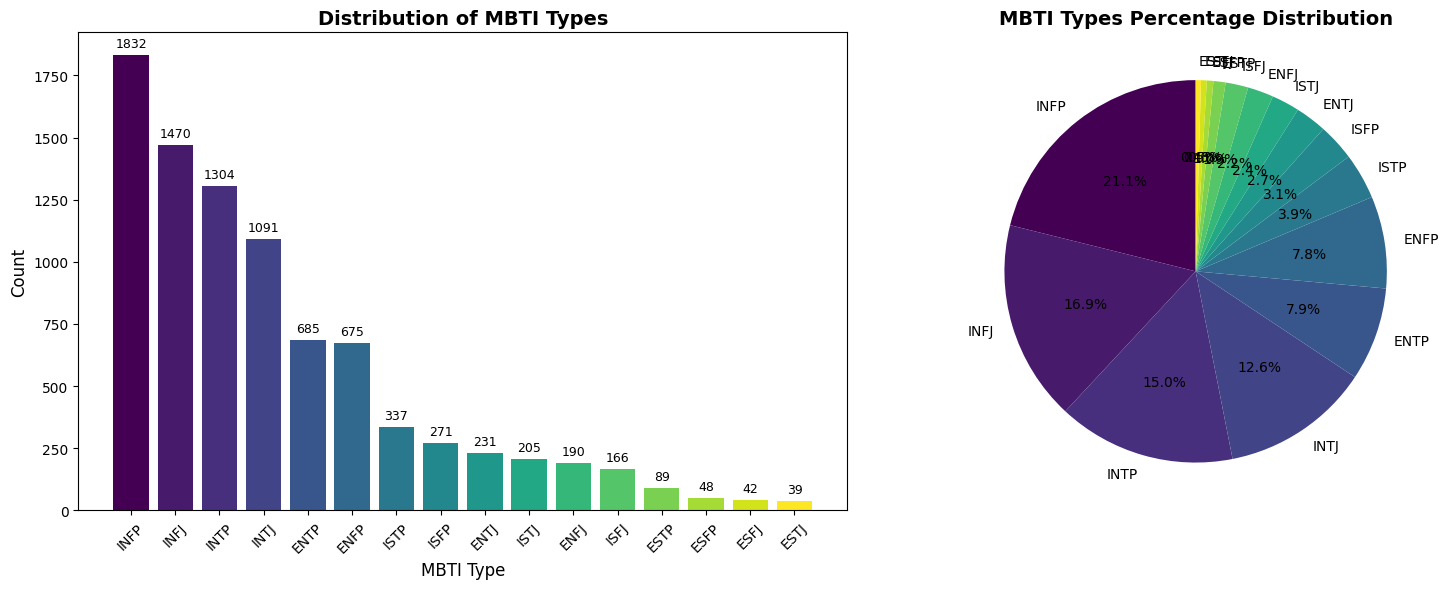


📈 Distribution Statistics:
   Most common type: INFP (1832 samples, 21.1%)
   Least common type: ESTJ (39 samples, 0.4%)
   Imbalance ratio: 46.97x


In [8]:
# ============================================
# 📊 MBTI TYPE DISTRIBUTION
# ============================================
print("=" * 60)
print("📊 MBTI TYPE DISTRIBUTION")
print("=" * 60)

# Count MBTI types
mbti_counts = df['type'].value_counts()
print(f"\n📋 MBTI Type Counts:")
print(mbti_counts)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(mbti_counts)))
bars = ax1.bar(mbti_counts.index, mbti_counts.values, color=colors)
ax1.set_xlabel('MBTI Type', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of MBTI Types', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
for bar, count in zip(bars, mbti_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             str(count), ha='center', va='bottom', fontsize=9)

# Pie chart
ax2 = axes[1]
ax2.pie(mbti_counts.values, labels=mbti_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('MBTI Types Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical summary
print(f"\n📈 Distribution Statistics:")
print(f"   Most common type: {mbti_counts.idxmax()} ({mbti_counts.max()} samples, {mbti_counts.max()/len(df)*100:.1f}%)")
print(f"   Least common type: {mbti_counts.idxmin()} ({mbti_counts.min()} samples, {mbti_counts.min()/len(df)*100:.1f}%)")
print(f"   Imbalance ratio: {mbti_counts.max()/mbti_counts.min():.2f}x")


### 2.3 Text Length Analysis


📏 TEXT LENGTH ANALYSIS

📊 Text Length Statistics:
         char_count   word_count   post_count  avg_word_length
count   8675.000000  8675.000000  8675.000000      8675.000000
mean    7234.989625  1226.241499    48.742939         5.008658
std     1607.806938   311.210544     5.475907         2.316698
min       57.000000     4.000000     1.000000         3.964231
25%     6325.000000  1046.500000    50.000000         4.669661
50%     7515.000000  1278.000000    50.000000         4.827356
75%     8429.000000  1457.000000    50.000000         5.042047
max    10090.000000  1881.000000    89.000000       141.809524


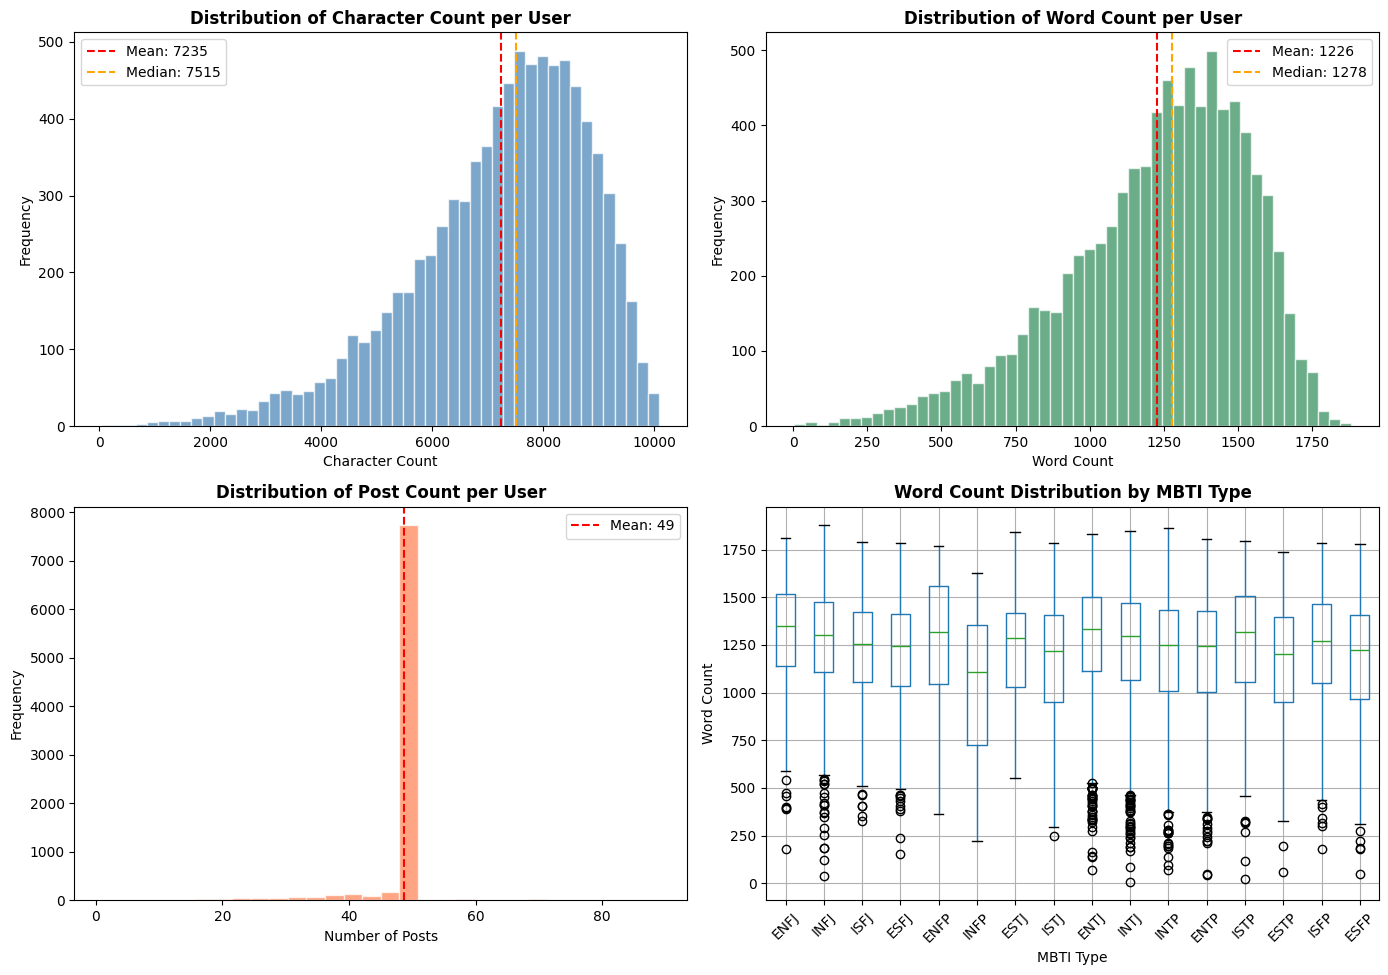


📋 Average Word Count by MBTI Type:
        mean    std  median
type                       
ESFJ  1290.5  352.0  1318.5
ENFJ  1286.6  311.1  1349.5
INFJ  1278.4  300.8  1335.5
ENFP  1260.8  299.5  1300.0
INFP  1244.6  309.0  1296.0
ISFJ  1241.3  357.3  1319.0
ESTJ  1229.5  299.4  1284.0
ENTJ  1218.1  289.9  1255.0
ISTJ  1213.2  329.3  1268.0
ENTP  1206.0  280.7  1242.0
INTP  1197.8  305.4  1246.5
INTJ  1194.6  317.8  1247.0
ISTP  1165.6  323.2  1221.0
ESTP  1162.6  323.4  1218.0
ISFP  1136.4  339.3  1200.0
ESFP  1022.1  390.5  1106.0


In [9]:
# ============================================
# 📏 TEXT LENGTH ANALYSIS
# ============================================
print("=" * 60)
print("📏 TEXT LENGTH ANALYSIS")
print("=" * 60)

# Calculate text statistics
df['char_count'] = df['posts'].apply(len)
df['word_count'] = df['posts'].apply(lambda x: len(x.split()))
df['post_count'] = df['posts'].apply(lambda x: len(x.split('|||')))
df['avg_word_length'] = df['posts'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)

print("\n📊 Text Length Statistics:")
print(df[['char_count', 'word_count', 'post_count', 'avg_word_length']].describe())

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Character count distribution
ax1 = axes[0, 0]
ax1.hist(df['char_count'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(df['char_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["char_count"].mean():.0f}')
ax1.axvline(df['char_count'].median(), color='orange', linestyle='--', label=f'Median: {df["char_count"].median():.0f}')
ax1.set_xlabel('Character Count')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Character Count per User', fontweight='bold')
ax1.legend()

# Word count distribution
ax2 = axes[0, 1]
ax2.hist(df['word_count'], bins=50, color='seagreen', edgecolor='white', alpha=0.7)
ax2.axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.0f}')
ax2.axvline(df['word_count'].median(), color='orange', linestyle='--', label=f'Median: {df["word_count"].median():.0f}')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Word Count per User', fontweight='bold')
ax2.legend()

# Post count distribution
ax3 = axes[1, 0]
ax3.hist(df['post_count'], bins=30, color='coral', edgecolor='white', alpha=0.7)
ax3.axvline(df['post_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["post_count"].mean():.0f}')
ax3.set_xlabel('Number of Posts')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Post Count per User', fontweight='bold')
ax3.legend()

# Word count by MBTI type (boxplot)
ax4 = axes[1, 1]
mbti_order = df.groupby('type')['word_count'].median().sort_values(ascending=False).index
df.boxplot(column='word_count', by='type', ax=ax4, positions=range(len(mbti_order)))
ax4.set_xticklabels(mbti_order, rotation=45)
ax4.set_xlabel('MBTI Type')
ax4.set_ylabel('Word Count')
ax4.set_title('Word Count Distribution by MBTI Type', fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Summary statistics by MBTI type
print("\n📋 Average Word Count by MBTI Type:")
word_count_by_type = df.groupby('type')['word_count'].agg(['mean', 'std', 'median']).round(1)
word_count_by_type = word_count_by_type.sort_values('mean', ascending=False)
print(word_count_by_type)


### 2.4 Word Cloud Analysis


☁️ WORD CLOUD ANALYSIS


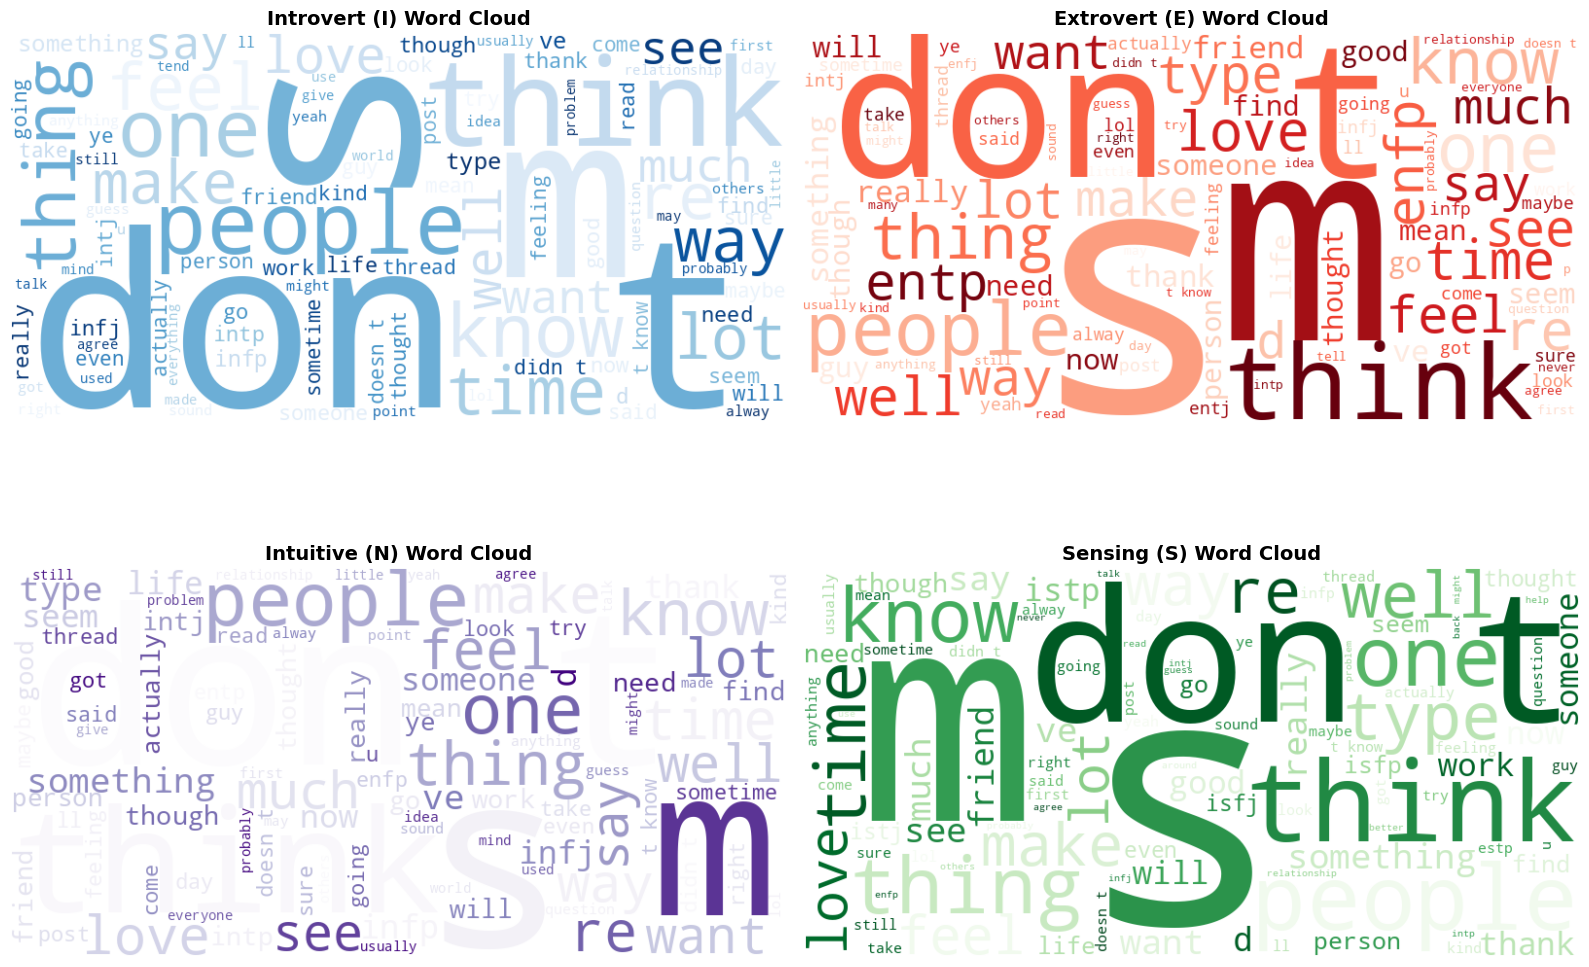

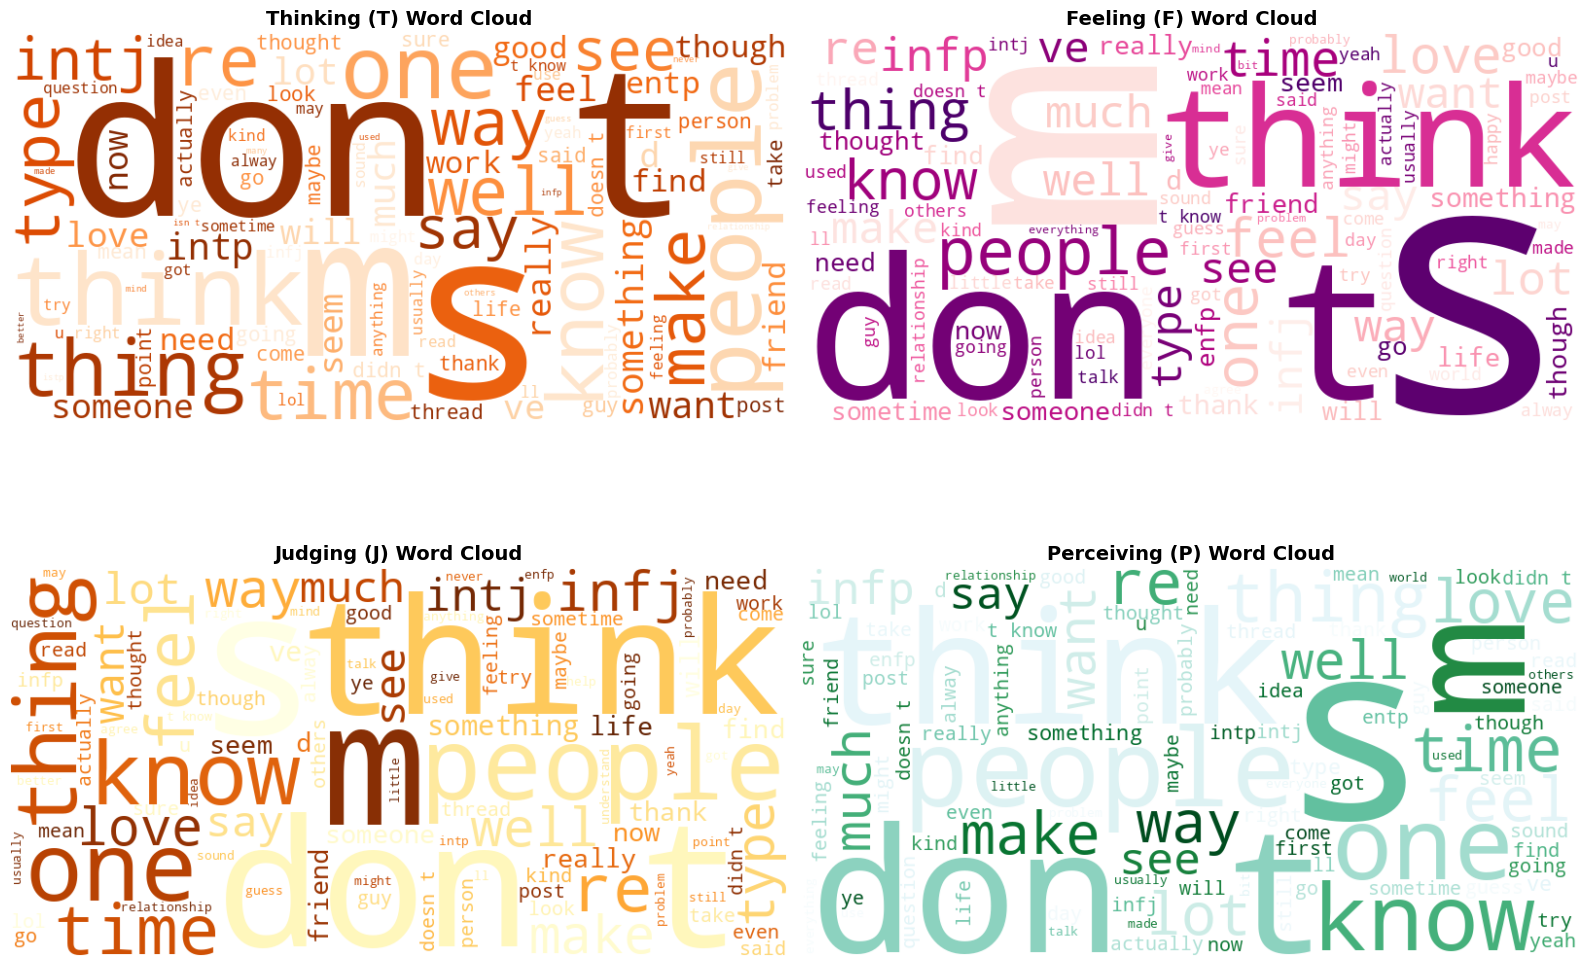

In [10]:
# ============================================
# ☁️ WORD CLOUD ANALYSIS
# ============================================
from wordcloud import WordCloud

print("=" * 60)
print("☁️ WORD CLOUD ANALYSIS")
print("=" * 60)

# Helper function for basic text cleaning (for word cloud only)
def simple_clean(text):
    text = text.replace('|||', ' ')
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())
    return text

# Create word clouds for different personality dimensions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Introvert vs Extrovert
introvert_text = ' '.join(df[df['type'].str.startswith('I')]['posts'].apply(simple_clean))
extrovert_text = ' '.join(df[df['type'].str.startswith('E')]['posts'].apply(simple_clean))

# Intuitive vs Sensing
intuitive_text = ' '.join(df[df['type'].str.contains('N')]['posts'].apply(simple_clean))
sensing_text = ' '.join(df[df['type'].str.contains('S')]['posts'].apply(simple_clean))

# Thinking vs Feeling
thinking_text = ' '.join(df[df['type'].str.contains('T')]['posts'].apply(simple_clean))
feeling_text = ' '.join(df[df['type'].str.contains('F')]['posts'].apply(simple_clean))

# Judging vs Perceiving
judging_text = ' '.join(df[df['type'].str.endswith('J')]['posts'].apply(simple_clean))
perceiving_text = ' '.join(df[df['type'].str.endswith('P')]['posts'].apply(simple_clean))

# Generate word clouds
wordcloud_intro = WordCloud(width=800, height=400, background_color='white', 
                            colormap='Blues', max_words=100).generate(introvert_text)
wordcloud_extro = WordCloud(width=800, height=400, background_color='white', 
                            colormap='Reds', max_words=100).generate(extrovert_text)
wordcloud_intuit = WordCloud(width=800, height=400, background_color='white', 
                             colormap='Purples', max_words=100).generate(intuitive_text)
wordcloud_sense = WordCloud(width=800, height=400, background_color='white', 
                            colormap='Greens', max_words=100).generate(sensing_text)

# Plot
axes[0, 0].imshow(wordcloud_intro, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('Introvert (I) Word Cloud', fontsize=14, fontweight='bold')

axes[0, 1].imshow(wordcloud_extro, interpolation='bilinear')
axes[0, 1].axis('off')
axes[0, 1].set_title('Extrovert (E) Word Cloud', fontsize=14, fontweight='bold')

axes[1, 0].imshow(wordcloud_intuit, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('Intuitive (N) Word Cloud', fontsize=14, fontweight='bold')

axes[1, 1].imshow(wordcloud_sense, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('Sensing (S) Word Cloud', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional word clouds for T/F and J/P
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

wordcloud_think = WordCloud(width=800, height=400, background_color='white', 
                            colormap='Oranges', max_words=100).generate(thinking_text)
wordcloud_feel = WordCloud(width=800, height=400, background_color='white', 
                           colormap='RdPu', max_words=100).generate(feeling_text)
wordcloud_judge = WordCloud(width=800, height=400, background_color='white', 
                            colormap='YlOrBr', max_words=100).generate(judging_text)
wordcloud_perc = WordCloud(width=800, height=400, background_color='white', 
                           colormap='BuGn', max_words=100).generate(perceiving_text)

axes[0, 0].imshow(wordcloud_think, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('Thinking (T) Word Cloud', fontsize=14, fontweight='bold')

axes[0, 1].imshow(wordcloud_feel, interpolation='bilinear')
axes[0, 1].axis('off')
axes[0, 1].set_title('Feeling (F) Word Cloud', fontsize=14, fontweight='bold')

axes[1, 0].imshow(wordcloud_judge, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('Judging (J) Word Cloud', fontsize=14, fontweight='bold')

axes[1, 1].imshow(wordcloud_perc, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('Perceiving (P) Word Cloud', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### 2.5 Word Frequency Analysis


📊 WORD FREQUENCY ANALYSIS


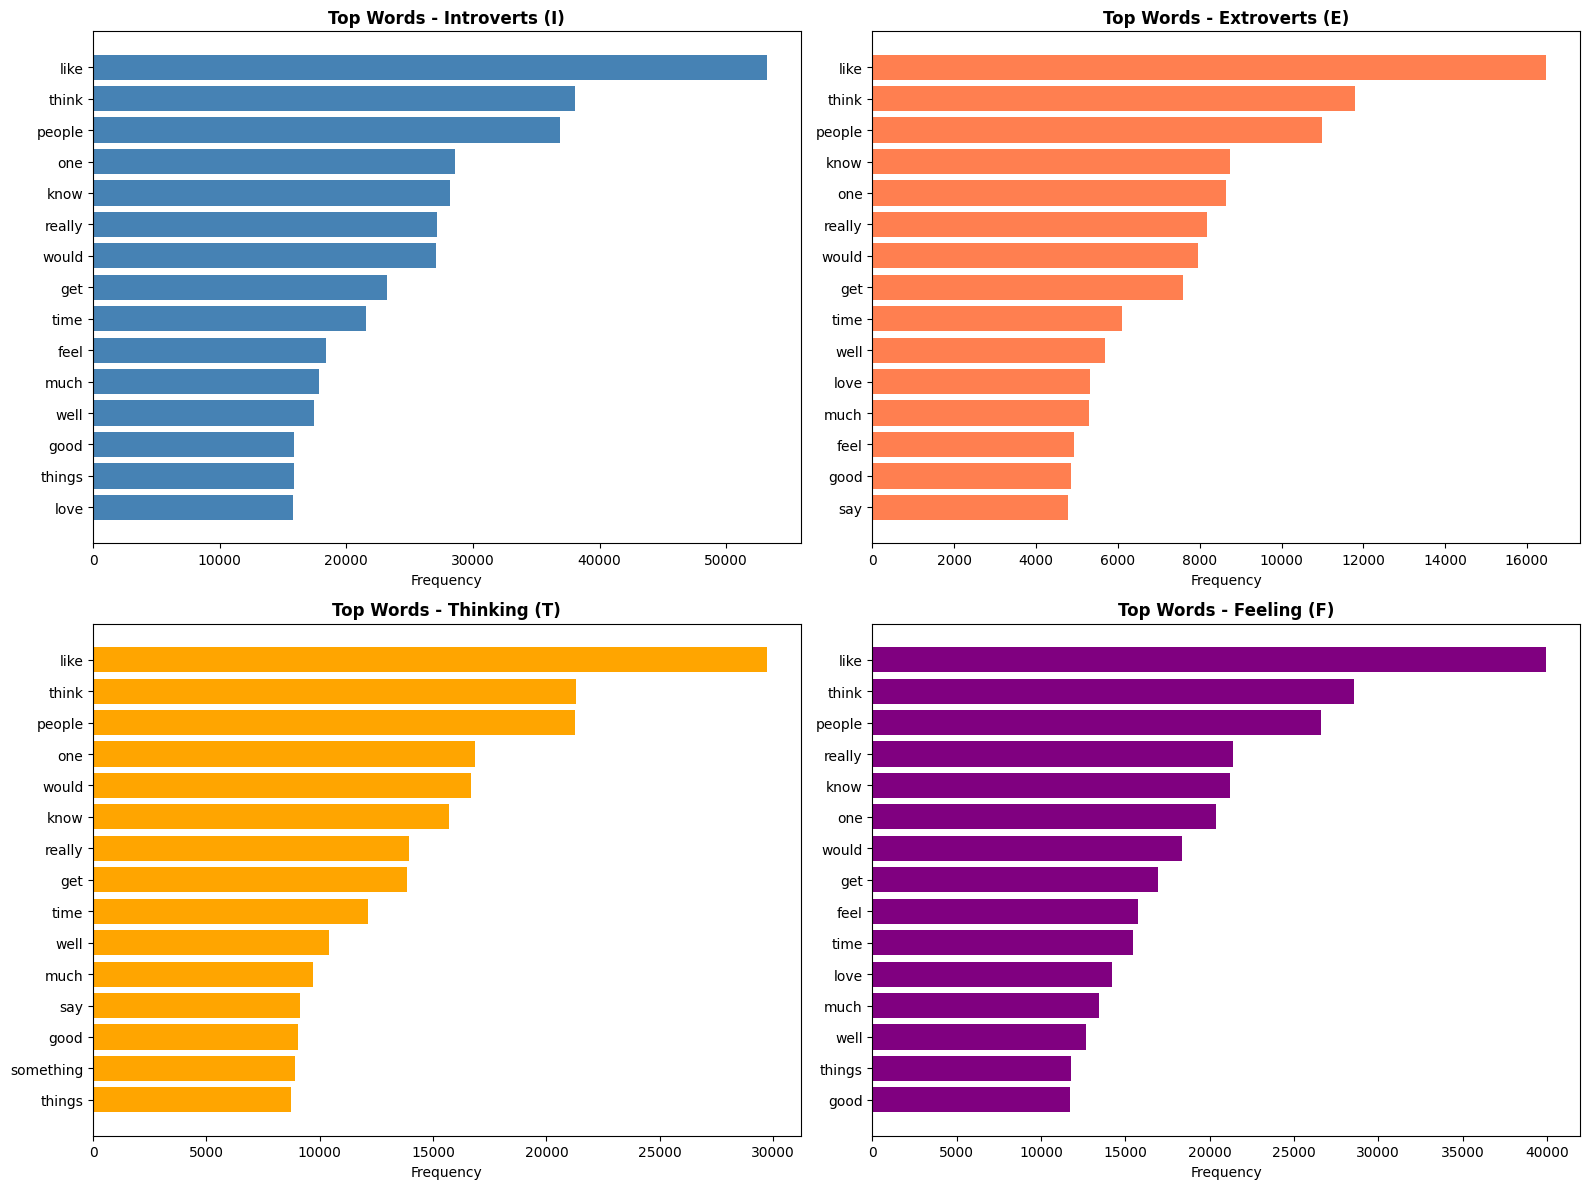


📝 Distinctive Words Analysis:
----------------------------------------

🔹 Unique to Introverts: {'things'}
🔹 Unique to Extroverts: {'say'}

🔹 Unique to Thinking: {'say', 'something'}
🔹 Unique to Feeling: {'love', 'feel'}


In [11]:
# ============================================
# 📊 WORD FREQUENCY ANALYSIS
# ============================================
from collections import Counter

print("=" * 60)
print("📊 WORD FREQUENCY ANALYSIS")
print("=" * 60)

# Get word frequencies for each dimension
def get_top_words(text, n=20):
    words = text.lower().split()
    # Remove stopwords and short words
    words = [w for w in words if w not in stop_words and len(w) > 2 and w.isalpha()]
    return Counter(words).most_common(n)

# Compare Introvert vs Extrovert
intro_words = get_top_words(introvert_text, 15)
extro_words = get_top_words(extrovert_text, 15)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Introvert top words
ax1 = axes[0, 0]
words_i, counts_i = zip(*intro_words)
ax1.barh(words_i[::-1], counts_i[::-1], color='steelblue')
ax1.set_xlabel('Frequency')
ax1.set_title('Top Words - Introverts (I)', fontweight='bold')

# Extrovert top words
ax2 = axes[0, 1]
words_e, counts_e = zip(*extro_words)
ax2.barh(words_e[::-1], counts_e[::-1], color='coral')
ax2.set_xlabel('Frequency')
ax2.set_title('Top Words - Extroverts (E)', fontweight='bold')

# Thinking vs Feeling
think_words = get_top_words(thinking_text, 15)
feel_words = get_top_words(feeling_text, 15)

ax3 = axes[1, 0]
words_t, counts_t = zip(*think_words)
ax3.barh(words_t[::-1], counts_t[::-1], color='orange')
ax3.set_xlabel('Frequency')
ax3.set_title('Top Words - Thinking (T)', fontweight='bold')

ax4 = axes[1, 1]
words_f, counts_f = zip(*feel_words)
ax4.barh(words_f[::-1], counts_f[::-1], color='purple')
ax4.set_xlabel('Frequency')
ax4.set_title('Top Words - Feeling (F)', fontweight='bold')

plt.tight_layout()
plt.show()

# Print unique words for each dimension
print("\n📝 Distinctive Words Analysis:")
print("-" * 40)

intro_set = set([w for w, _ in intro_words])
extro_set = set([w for w, _ in extro_words])
print(f"\n🔹 Unique to Introverts: {intro_set - extro_set}")
print(f"🔹 Unique to Extroverts: {extro_set - intro_set}")

think_set = set([w for w, _ in think_words])
feel_set = set([w for w, _ in feel_words])
print(f"\n🔹 Unique to Thinking: {think_set - feel_set}")
print(f"🔹 Unique to Feeling: {feel_set - think_set}")


### 2.6 Sample Posts Exploration


In [12]:
# ============================================
# 📝 SAMPLE POSTS EXPLORATION
# ============================================
print("=" * 60)
print("📝 SAMPLE POSTS EXPLORATION")
print("=" * 60)

# Show sample posts for different MBTI types
sample_types = ['INTJ', 'ENFP', 'ISTJ', 'ENTP']

for mbti_type in sample_types:
    print(f"\n{'='*60}")
    print(f"📌 Sample Post from {mbti_type}:")
    print(f"{'='*60}")
    sample = df[df['type'] == mbti_type]['posts'].iloc[0]
    # Split by ||| and show first 3 posts
    posts = sample.split('|||')[:3]
    for i, post in enumerate(posts, 1):
        print(f"\n   Post {i}: {post[:200]}..." if len(post) > 200 else f"\n   Post {i}: {post}")


📝 SAMPLE POSTS EXPLORATION

📌 Sample Post from INTJ:

   Post 1: 'Dear INTP,   I enjoyed our conversation the other day.  Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...

   Post 2: Dear ENTJ sub,   Long time no see.  Sincerely, Alpha

   Post 3: None of them. All other types hurt in deep existential ways that I want no part of.

📌 Sample Post from ENFP:

   Post 1: 'He doesn't want to go on the trip without me, so me staying behind wouldn't be an option for him. I think he really does believe that I'm the one being unreasonable. He still continues to say that...

   Post 2: I'm still completely in AWE and I'm AMAZED that he doesn't think twice about leaving one of them and how that will make them feel. He said he wants to tell them that I'm not willing to work extra for....

   Post 3: Thanks, everyone. I'm struggling with being selfish and not just going ahead and working to pay for the rest. I don't

### 2.7 Correlation Analysis & Dataset Summary


🔗 CORRELATION ANALYSIS & DATASET SUMMARY


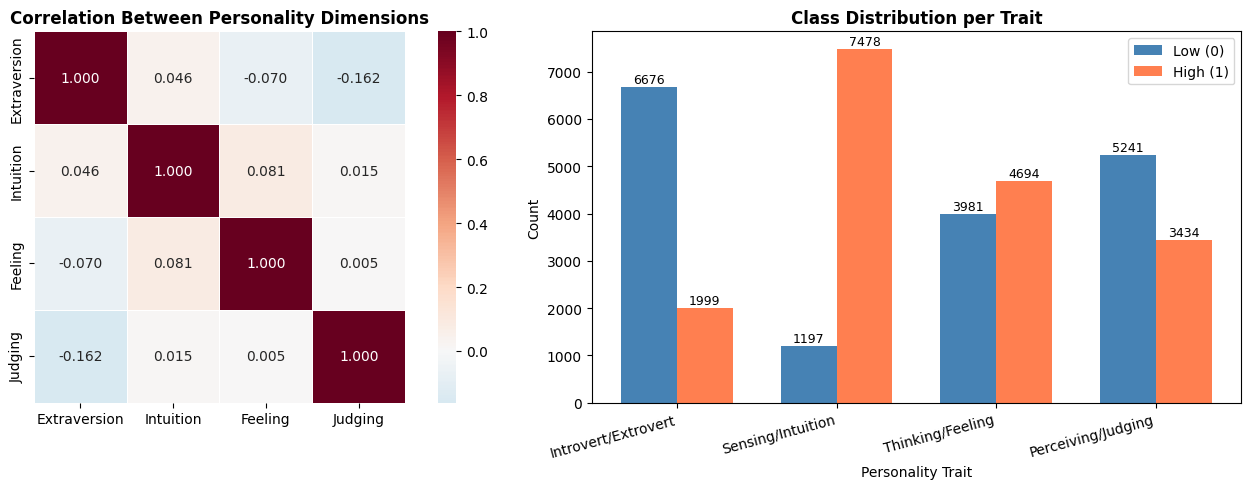


📊 DATASET SUMMARY FOR CLASSIFICATION

🎯 Extraversion:
   Low (0): 6676 (77.0%)
   High (1): 1999 (23.0%)
   Imbalance Ratio: 0.30
   ⚠️  Significant class imbalance detected!

🎯 Intuition:
   Low (0): 1197 (13.8%)
   High (1): 7478 (86.2%)
   Imbalance Ratio: 6.25
   ⚠️  Significant class imbalance detected!

🎯 Feeling:
   Low (0): 3981 (45.9%)
   High (1): 4694 (54.1%)
   Imbalance Ratio: 1.18

🎯 Judging:
   Low (0): 5241 (60.4%)
   High (1): 3434 (39.6%)
   Imbalance Ratio: 0.66


In [13]:
# ============================================
# 🔗 CORRELATION ANALYSIS & DATASET SUMMARY
# ============================================
print("=" * 60)
print("🔗 CORRELATION ANALYSIS & DATASET SUMMARY")
print("=" * 60)

# First, map MBTI to binary traits for correlation analysis
df_temp = df.copy()
df_temp['E_I'] = df_temp['type'].apply(lambda x: 1 if 'E' in x else 0)  # 1=Extrovert
df_temp['N_S'] = df_temp['type'].apply(lambda x: 1 if 'N' in x else 0)  # 1=Intuitive
df_temp['F_T'] = df_temp['type'].apply(lambda x: 1 if 'F' in x else 0)  # 1=Feeling
df_temp['J_P'] = df_temp['type'].apply(lambda x: 1 if 'J' in x else 0)  # 1=Judging

# Correlation matrix for personality dimensions
trait_cols = ['E_I', 'N_S', 'F_T', 'J_P']
trait_names = ['Extraversion', 'Intuition', 'Feeling', 'Judging']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
ax1 = axes[0]
corr_matrix = df_temp[trait_cols].corr()
corr_matrix.index = trait_names
corr_matrix.columns = trait_names
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, ax=ax1, 
            fmt='.3f', square=True, linewidths=0.5)
ax1.set_title('Correlation Between Personality Dimensions', fontsize=12, fontweight='bold')

# Class distribution
ax2 = axes[1]
class_dist = pd.DataFrame({
    'Trait': trait_names * 2,
    'Class': ['Low'] * 4 + ['High'] * 4,
    'Count': [
        (df_temp['E_I'] == 0).sum(), (df_temp['N_S'] == 0).sum(), 
        (df_temp['F_T'] == 0).sum(), (df_temp['J_P'] == 0).sum(),
        (df_temp['E_I'] == 1).sum(), (df_temp['N_S'] == 1).sum(), 
        (df_temp['F_T'] == 1).sum(), (df_temp['J_P'] == 1).sum()
    ]
})

x = np.arange(len(trait_names))
width = 0.35
low_counts = [(df_temp[col] == 0).sum() for col in trait_cols]
high_counts = [(df_temp[col] == 1).sum() for col in trait_cols]

bars1 = ax2.bar(x - width/2, low_counts, width, label='Low (0)', color='steelblue')
bars2 = ax2.bar(x + width/2, high_counts, width, label='High (1)', color='coral')

ax2.set_xlabel('Personality Trait')
ax2.set_ylabel('Count')
ax2.set_title('Class Distribution per Trait', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Introvert/Extrovert', 'Sensing/Intuition', 'Thinking/Feeling', 'Perceiving/Judging'], 
                    rotation=15, ha='right')
ax2.legend()

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax2.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Statistical summary
print("\n📊 DATASET SUMMARY FOR CLASSIFICATION")
print("=" * 60)

for col, name in zip(trait_cols, trait_names):
    low = (df_temp[col] == 0).sum()
    high = (df_temp[col] == 1).sum()
    ratio = high / low if low > 0 else float('inf')
    print(f"\n🎯 {name}:")
    print(f"   Low (0): {low} ({low/len(df_temp)*100:.1f}%)")
    print(f"   High (1): {high} ({high/len(df_temp)*100:.1f}%)")
    print(f"   Imbalance Ratio: {ratio:.2f}")
    if ratio < 0.5 or ratio > 2:
        print(f"   ⚠️  Significant class imbalance detected!")


---
## 3. 📊 Traditional ML Approach (TF-IDF + Classical Models)


In [14]:
# ============================================
# 🔤 TF-IDF VECTORIZATION
# ============================================
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.95)
X_tfidf = tfidf.fit_transform(df['clean_posts'])
print(f"✅ TF-IDF shape: {X_tfidf.shape}")


Creating TF-IDF features...
✅ TF-IDF shape: (8675, 10000)


In [15]:
# ============================================
# 🤖 TRAIN TRADITIONAL ML MODELS
# ============================================
from sklearn.naive_bayes import MultinomialNB

def train_ml_models(X, y, trait_name):
    """Train and evaluate multiple ML models with SMOTE"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    
    # Apply SMOTE
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    
    # Calculate class weight for XGBoost
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
        'Linear SVM': LinearSVC(class_weight='balanced', random_state=RANDOM_STATE, max_iter=2000),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
        'Naive Bayes': MultinomialNB(alpha=1.0),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='logloss',
                                  scale_pos_weight=scale_pos_weight, n_jobs=-1)
    }
    
    results = []
    all_models = {}
    best_model = None
    best_f1 = 0
    
    for name, model in models.items():
        # Naive Bayes needs non-negative data (use original, not SMOTE resampled for NB)
        if name == 'Naive Bayes':
            model.fit(X_train, y_train)  # NB doesn't work well with SMOTE
        else:
            model.fit(X_train_sm, y_train_sm)
        
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results.append({'Model': name, 'Accuracy': acc, 'F1': f1})
        all_models[name] = model
        
        if f1 > best_f1:
            best_f1 = f1
            best_model = (name, model)
    
    return pd.DataFrame(results), best_model, all_models, y_test, y_pred

# Train for all traits
print("🚀 Training Traditional ML Models (5 models per trait)...")
print("="*60)

ml_results = {}
ml_all_models = {}

for trait in TARGET_TRAITS:
    print(f"\n🎯 {trait}:")
    results_df, best, all_models, y_test, y_pred = train_ml_models(X_tfidf, df[trait], trait)
    ml_results[trait] = {'results': results_df, 'best': best}
    ml_all_models[trait] = all_models
    print(results_df.sort_values('F1', ascending=False).to_string(index=False))
    print(f"   🏆 Best: {best[0]} (F1: {results_df[results_df['Model']==best[0]]['F1'].values[0]:.4f})")


🚀 Training Traditional ML Models (5 models per trait)...

🎯 Extraversion:
              Model  Accuracy       F1
Logistic Regression  0.790778 0.791939
         Linear SVM  0.780403 0.775679
            XGBoost  0.771182 0.761934
      Random Forest  0.773487 0.682691
        Naive Bayes  0.769452 0.669198
   🏆 Best: Logistic Regression (F1: 0.7919)

🎯 Openness:
              Model  Accuracy       F1
Logistic Regression  0.851297 0.853782
         Linear SVM  0.850144 0.849069
            XGBoost  0.844957 0.840376
      Random Forest  0.861671 0.800359
        Naive Bayes  0.862248 0.798467
   🏆 Best: Logistic Regression (F1: 0.8538)

🎯 Agreeableness:
              Model  Accuracy       F1
Logistic Regression  0.795389 0.795727
         Linear SVM  0.768876 0.769167
        Naive Bayes  0.770029 0.767152
            XGBoost  0.762536 0.762852
      Random Forest  0.748703 0.748628
   🏆 Best: Logistic Regression (F1: 0.7957)

🎯 Conscientiousness:
              Model  Accuracy       F1


### 3.1 Confusion Matrix Analysis


📊 CONFUSION MATRIX ANALYSIS


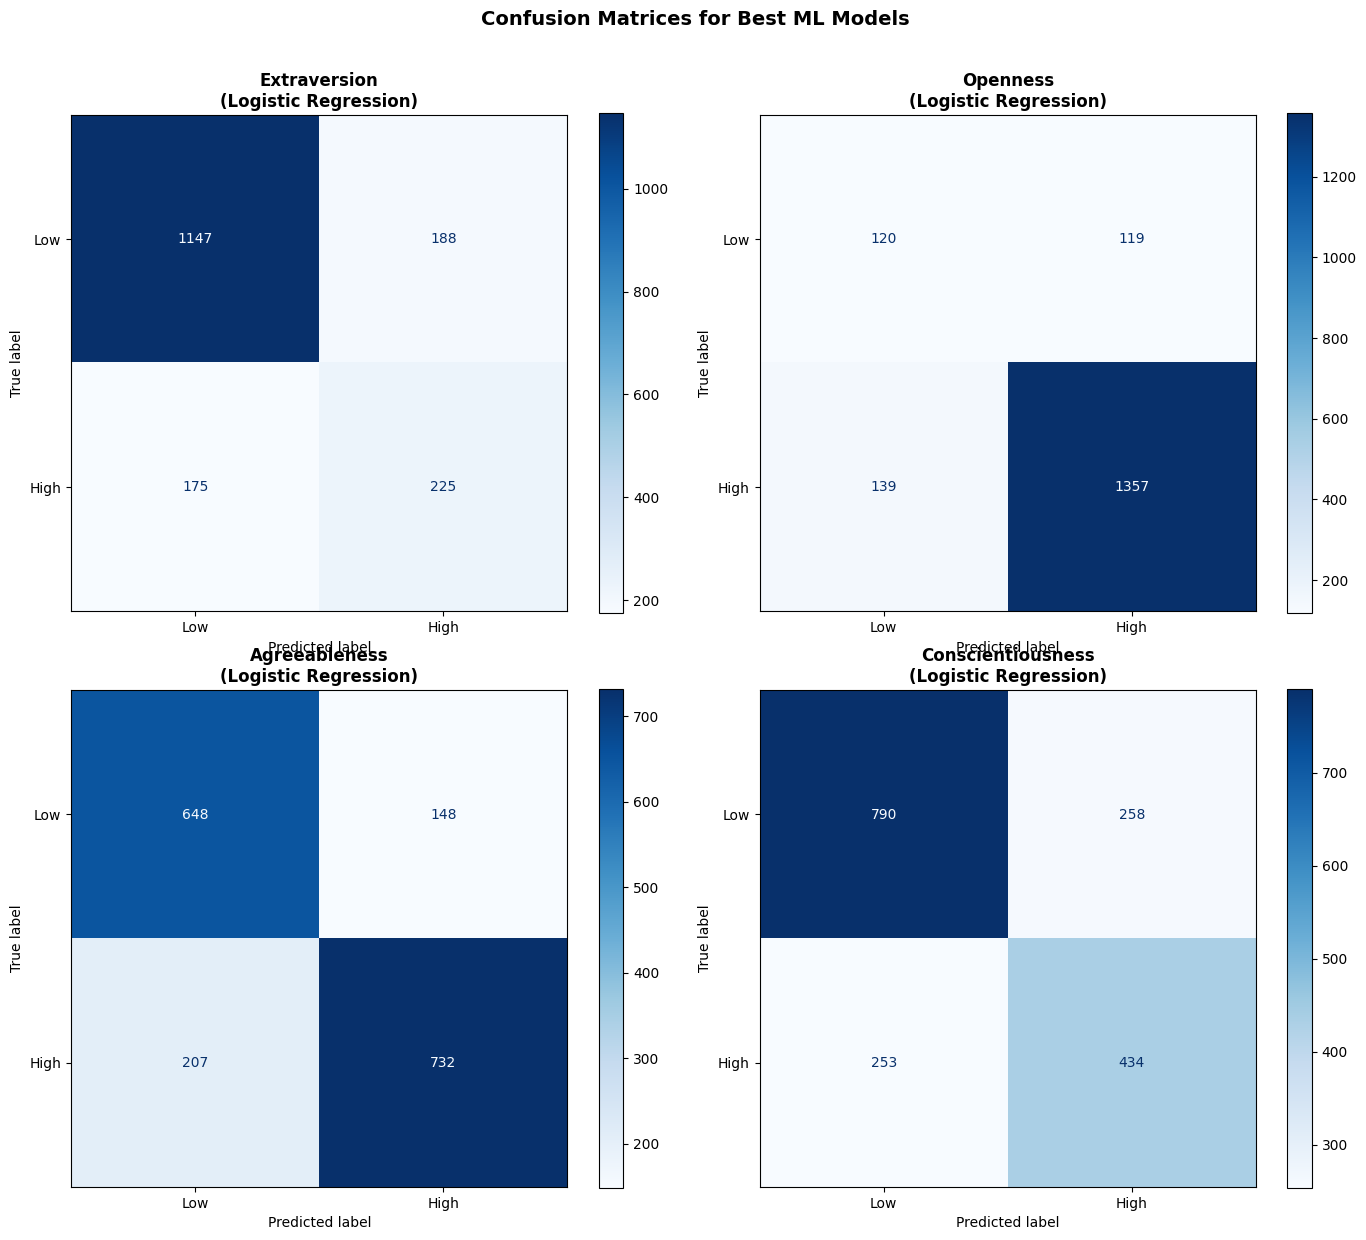


📋 DETAILED CLASSIFICATION REPORTS

🎯 Extraversion (Logistic Regression):
----------------------------------------
              precision    recall  f1-score   support

         Low       0.87      0.86      0.86      1335
        High       0.54      0.56      0.55       400

    accuracy                           0.79      1735
   macro avg       0.71      0.71      0.71      1735
weighted avg       0.79      0.79      0.79      1735


🎯 Openness (Logistic Regression):
----------------------------------------
              precision    recall  f1-score   support

         Low       0.46      0.50      0.48       239
        High       0.92      0.91      0.91      1496

    accuracy                           0.85      1735
   macro avg       0.69      0.70      0.70      1735
weighted avg       0.86      0.85      0.85      1735


🎯 Agreeableness (Logistic Regression):
----------------------------------------
              precision    recall  f1-score   support

         Low       

In [16]:
# ============================================
# 📊 CONFUSION MATRIX ANALYSIS
# ============================================
from sklearn.metrics import ConfusionMatrixDisplay

print("=" * 60)
print("📊 CONFUSION MATRIX ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, trait in enumerate(TARGET_TRAITS):
    ax = axes[idx // 2, idx % 2]
    
    # Get the best model for this trait
    best_model_name, best_model = ml_results[trait]['best']
    
    # Make predictions on test set
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, df[trait], test_size=0.2, random_state=RANDOM_STATE, stratify=df[trait]
    )
    
    y_pred = best_model.predict(X_test)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'High'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{trait}\n({best_model_name})', fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices for Best ML Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print classification reports
print("\n📋 DETAILED CLASSIFICATION REPORTS")
print("=" * 60)

for trait in TARGET_TRAITS:
    print(f"\n🎯 {trait} ({ml_results[trait]['best'][0]}):")
    print("-" * 40)
    
    best_model = ml_results[trait]['best'][1]
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, df[trait], test_size=0.2, random_state=RANDOM_STATE, stratify=df[trait]
    )
    y_pred = best_model.predict(X_test)
    
    print(classification_report(y_test, y_pred, target_names=['Low', 'High']))


### 3.2 Feature Importance Analysis


🔍 FEATURE IMPORTANCE ANALYSIS


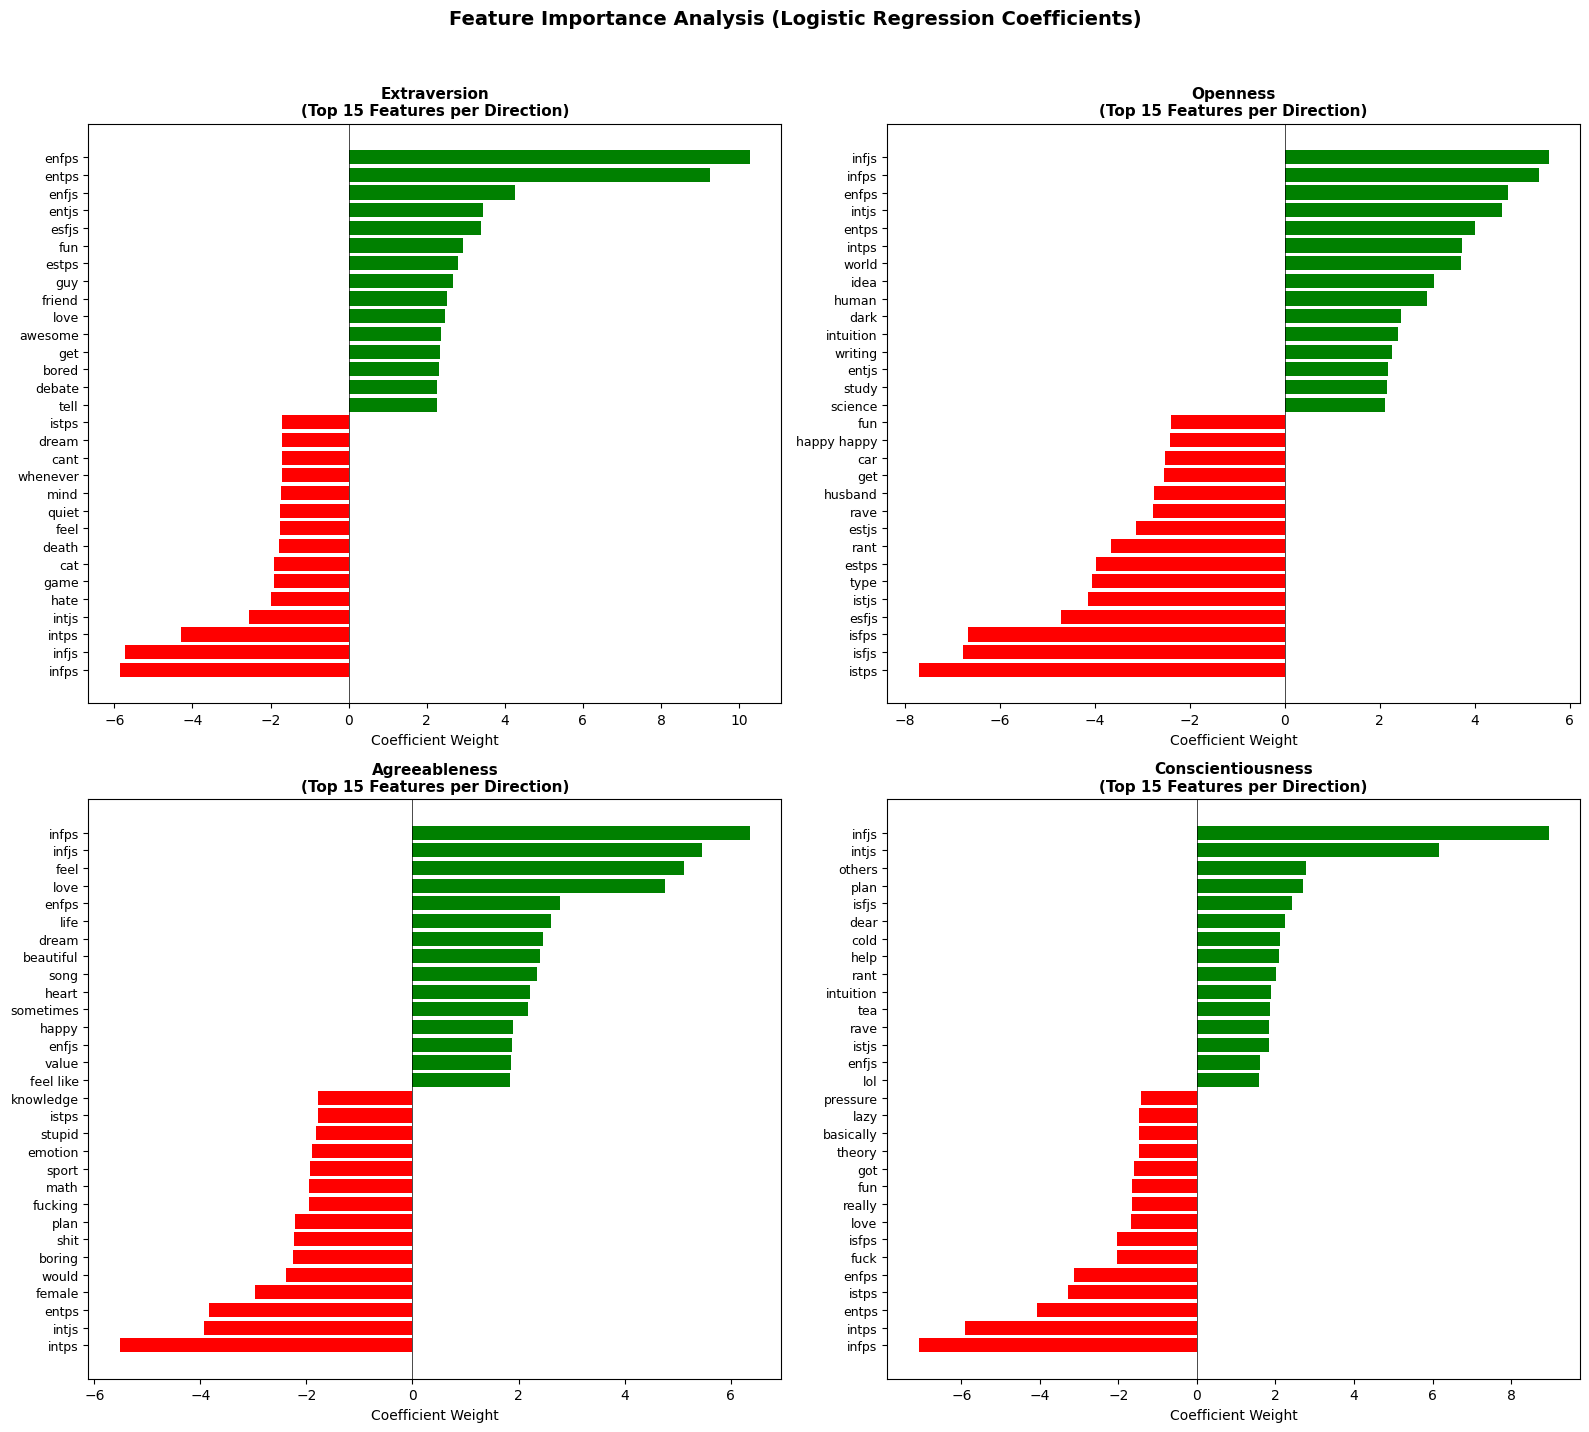


📋 TOP 10 MOST IMPORTANT FEATURES PER TRAIT

🎯 Extraversion:
----------------------------------------
   📈 Features indicating HIGH:
      enfps: 10.2712
      entps: 9.2573
      enfjs: 4.2611
      entjs: 3.4346
      esfjs: 3.4004
      fun: 2.9317
      estps: 2.8072
      guy: 2.6791
      friend: 2.5184
      love: 2.4644
   📉 Features indicating LOW:
      infps: -5.8567
      infjs: -5.7209
      intps: -4.3021
      intjs: -2.5606
      hate: -1.9821
      game: -1.9161
      cat: -1.9004
      death: -1.7871
      feel: -1.7633
      quiet: -1.7521

🎯 Openness:
----------------------------------------
   📈 Features indicating HIGH:
      infjs: 5.5534
      infps: 5.3550
      enfps: 4.7086
      intjs: 4.5690
      entps: 3.9992
      intps: 3.7337
      world: 3.7043
      idea: 3.1423
      human: 2.9901
      dark: 2.4492
   📉 Features indicating LOW:
      istps: -7.7007
      isfjs: -6.7694
      isfps: -6.6727
      esfjs: -4.7146
      istjs: -4.1404
      type: -4.06

In [17]:
# ============================================
# 🔍 FEATURE IMPORTANCE ANALYSIS
# ============================================
print("=" * 60)
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature names from TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for idx, trait in enumerate(TARGET_TRAITS):
    ax = axes[idx // 2, idx % 2]
    
    # Get the best model
    best_model_name, best_model = ml_results[trait]['best']
    
    # Get feature importance/coefficients
    if hasattr(best_model, 'coef_'):
        # For Logistic Regression, SVM
        importance = best_model.coef_[0]
    elif hasattr(best_model, 'feature_importances_'):
        # For Random Forest, XGBoost
        importance = best_model.feature_importances_
    else:
        continue
    
    # Get top positive and negative features
    n_features = 15
    top_positive_idx = np.argsort(importance)[-n_features:]
    top_negative_idx = np.argsort(importance)[:n_features]
    
    # Combine and sort
    top_idx = np.concatenate([top_negative_idx, top_positive_idx])
    top_features = feature_names[top_idx]
    top_importance = importance[top_idx]
    
    # Plot
    colors = ['red' if x < 0 else 'green' for x in top_importance]
    ax.barh(range(len(top_features)), top_importance, color=colors)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features, fontsize=9)
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.set_xlabel('Coefficient Weight')
    ax.set_title(f'{trait}\n(Top {n_features} Features per Direction)', fontsize=11, fontweight='bold')

plt.suptitle('Feature Importance Analysis (Logistic Regression Coefficients)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print top features for each trait
print("\n📋 TOP 10 MOST IMPORTANT FEATURES PER TRAIT")
print("=" * 60)

for trait in TARGET_TRAITS:
    print(f"\n🎯 {trait}:")
    print("-" * 40)
    
    best_model = ml_results[trait]['best'][1]
    
    if hasattr(best_model, 'coef_'):
        importance = best_model.coef_[0]
        
        # Top features for HIGH
        top_high_idx = np.argsort(importance)[-10:][::-1]
        print("   📈 Features indicating HIGH:")
        for i in top_high_idx:
            print(f"      {feature_names[i]}: {importance[i]:.4f}")
        
        # Top features for LOW
        top_low_idx = np.argsort(importance)[:10]
        print("   📉 Features indicating LOW:")
        for i in top_low_idx:
            print(f"      {feature_names[i]}: {importance[i]:.4f}")


### 3.3 Cross-Validation Analysis


🔄 CROSS-VALIDATION ANALYSIS (5-Fold)

🎯 Extraversion:
----------------------------------------
   Model: Logistic Regression
   CV F1 Scores: [0.7794 0.7733 0.7776 0.7875 0.7972]
   Mean F1: 0.7830 (+/- 0.0170)

🎯 Openness:
----------------------------------------
   Model: Logistic Regression
   CV F1 Scores: [0.8437 0.8494 0.8372 0.8349 0.8369]
   Mean F1: 0.8404 (+/- 0.0108)

🎯 Agreeableness:
----------------------------------------
   Model: Logistic Regression
   CV F1 Scores: [0.8347 0.8159 0.8053 0.8038 0.813 ]
   Mean F1: 0.8145 (+/- 0.0221)

🎯 Conscientiousness:
----------------------------------------
   Model: Logistic Regression
   CV F1 Scores: [0.7107 0.7047 0.7195 0.6874 0.6948]
   Mean F1: 0.7034 (+/- 0.0227)


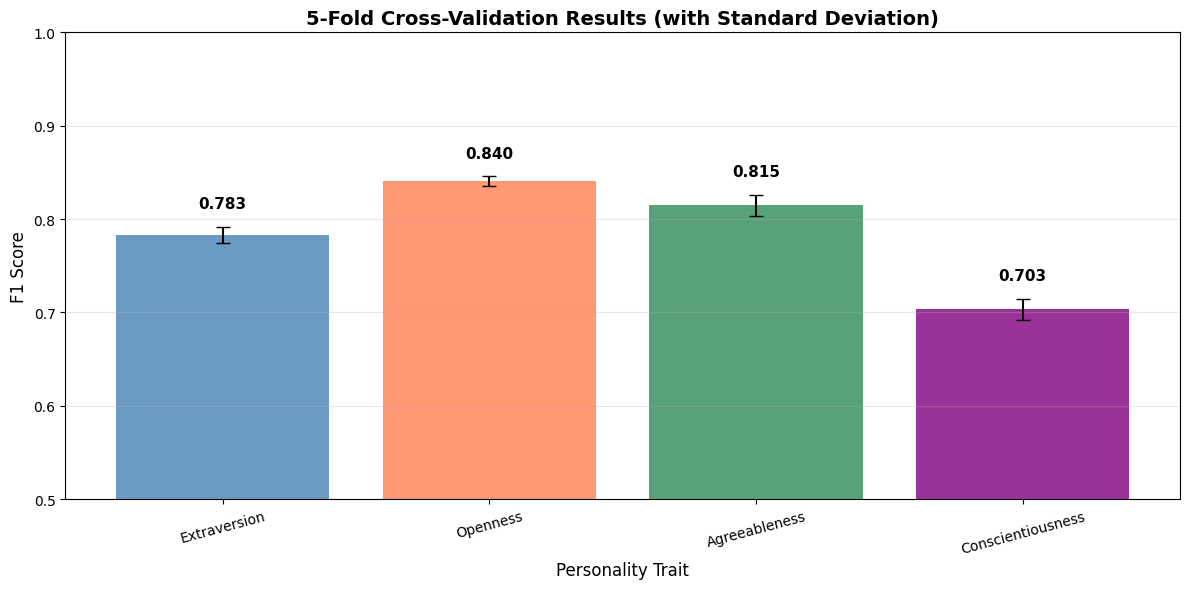


📊 CROSS-VALIDATION SUMMARY
            Trait  Mean F1  Std Dev  95% CI Lower  95% CI Upper
     Extraversion   0.7830   0.0085        0.7660        0.7999
         Openness   0.8404   0.0054        0.8297        0.8512
    Agreeableness   0.8145   0.0111        0.7924        0.8367
Conscientiousness   0.7034   0.0114        0.6807        0.7261


In [18]:
# ============================================
# 🔄 CROSS-VALIDATION ANALYSIS
# ============================================
from sklearn.model_selection import cross_val_score

print("=" * 60)
print("🔄 CROSS-VALIDATION ANALYSIS (5-Fold)")
print("=" * 60)

cv_results = {}

for trait in TARGET_TRAITS:
    print(f"\n🎯 {trait}:")
    print("-" * 40)
    
    best_model_name, best_model = ml_results[trait]['best']
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(best_model, X_tfidf, df[trait], cv=5, scoring='f1_weighted')
    
    cv_results[trait] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"   Model: {best_model_name}")
    print(f"   CV F1 Scores: {cv_scores.round(4)}")
    print(f"   Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

traits = list(cv_results.keys())
means = [cv_results[t]['mean'] for t in traits]
stds = [cv_results[t]['std'] for t in traits]

x = np.arange(len(traits))
bars = ax.bar(x, means, yerr=stds, capsize=5, color=['steelblue', 'coral', 'seagreen', 'purple'], alpha=0.8)

ax.set_xlabel('Personality Trait', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('5-Fold Cross-Validation Results (with Standard Deviation)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(traits, rotation=15)
ax.set_ylim(0.5, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02, 
            f'{mean:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary table
print("\n📊 CROSS-VALIDATION SUMMARY")
print("=" * 60)
cv_summary = pd.DataFrame({
    'Trait': traits,
    'Mean F1': means,
    'Std Dev': stds,
    '95% CI Lower': [m - 2*s for m, s in zip(means, stds)],
    '95% CI Upper': [m + 2*s for m, s in zip(means, stds)]
}).round(4)
print(cv_summary.to_string(index=False))


### 3.4 Error Analysis


In [19]:
# ============================================
# ❌ ERROR ANALYSIS
# ============================================
print("=" * 60)
print("❌ ERROR ANALYSIS")
print("=" * 60)

# Analyze misclassified samples for Extraversion (most intuitive trait)
trait = 'Extraversion'
print(f"\n🔍 Analyzing misclassified samples for: {trait}")
print("-" * 50)

# Split and predict
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df[trait], test_size=0.2, random_state=RANDOM_STATE, stratify=df[trait]
)

# Get test indices
test_indices = y_test.index.tolist()

best_model = ml_results[trait]['best'][1]
y_pred = best_model.predict(X_test)

# Find misclassified samples
misclassified_mask = y_pred != y_test.values
misclassified_indices = [test_indices[i] for i in range(len(test_indices)) if misclassified_mask[i]]

print(f"\n📊 Misclassification Statistics:")
print(f"   Total test samples: {len(y_test)}")
print(f"   Misclassified: {sum(misclassified_mask)} ({sum(misclassified_mask)/len(y_test)*100:.1f}%)")
print(f"   Correctly classified: {len(y_test) - sum(misclassified_mask)}")

# Analyze false positives and false negatives
false_positives = sum((y_pred == 1) & (y_test.values == 0))
false_negatives = sum((y_pred == 0) & (y_test.values == 1))
print(f"\n   False Positives (Predicted High, Actual Low): {false_positives}")
print(f"   False Negatives (Predicted Low, Actual High): {false_negatives}")

# Show sample misclassified texts
print("\n📝 Sample Misclassified Texts:")
print("-" * 50)

# False Negatives (Extroverts predicted as Introverts)
fn_indices = [test_indices[i] for i in range(len(test_indices)) 
              if (y_pred[i] == 0) and (y_test.values[i] == 1)]

if fn_indices:
    print("\n🔴 False Negatives (Extroverts predicted as Introverts):")
    for i, idx in enumerate(fn_indices[:2]):
        print(f"\n   Sample {i+1}:")
        text = df.loc[idx, 'posts']
        posts = text.split('|||')[:2]
        for j, post in enumerate(posts):
            truncated = post[:150] + "..." if len(post) > 150 else post
            print(f"      Post {j+1}: {truncated}")

# False Positives (Introverts predicted as Extroverts)
fp_indices = [test_indices[i] for i in range(len(test_indices)) 
              if (y_pred[i] == 1) and (y_test.values[i] == 0)]

if fp_indices:
    print("\n🔵 False Positives (Introverts predicted as Extroverts):")
    for i, idx in enumerate(fp_indices[:2]):
        print(f"\n   Sample {i+1}:")
        text = df.loc[idx, 'posts']
        posts = text.split('|||')[:2]
        for j, post in enumerate(posts):
            truncated = post[:150] + "..." if len(post) > 150 else post
            print(f"      Post {j+1}: {truncated}")

# Error rate by text length
print("\n📊 Error Rate Analysis by Text Length:")
print("-" * 50)

test_df = df.loc[test_indices].copy()
test_df['predicted'] = y_pred
test_df['correct'] = (y_pred == y_test.values)

# Bin by word count
test_df['length_bin'] = pd.cut(test_df['word_count'], bins=[0, 500, 1000, 1500, float('inf')], 
                                labels=['Short (<500)', 'Medium (500-1000)', 'Long (1000-1500)', 'Very Long (>1500)'])

length_accuracy = test_df.groupby('length_bin')['correct'].mean()
print("\n   Accuracy by Text Length:")
for length, acc in length_accuracy.items():
    print(f"      {length}: {acc:.2%}")


❌ ERROR ANALYSIS

🔍 Analyzing misclassified samples for: Extraversion
--------------------------------------------------

📊 Misclassification Statistics:
   Total test samples: 1735
   Misclassified: 363 (20.9%)
   Correctly classified: 1372

   False Positives (Predicted High, Actual Low): 188
   False Negatives (Predicted Low, Actual High): 175

📝 Sample Misclassified Texts:
--------------------------------------------------

🔴 False Negatives (Extroverts predicted as Introverts):

   Sample 1:
      Post 1: Peeeace.  And maybe a genie to grant me three wishes. Hey, if any of you guys find an old lamp, can I has it?
      Post 2: When's the last time you checked up on the kids, ENTJ?

   Sample 2:
      Post 1: 'Oh I have read 1984, it is a very good book. And continued thanks, I currently am hooked on the sequel to 1632 by Eric Flint I would strongly recomme...
      Post 2: That looks very good and I will pick it up sometime in the future. Maybe next week, have spring break and lot

---
## 4. 🚀 Deep Learning Approach (BERT - GPU Accelerated)

This section uses DistilBERT for faster training while maintaining good performance.


In [20]:
# ============================================
# 🤗 BERT CONFIGURATION
# ============================================
MODEL_NAME = "distilbert-base-uncased"  # Faster than BERT, good performance
MAX_LENGTH = 256  # Reduced for memory efficiency
BATCH_SIZE = 16 if torch.cuda.is_available() else 8
EPOCHS = 3
LEARNING_RATE = 2e-5

print(f"📋 BERT Configuration:")
print(f"   Model: {MODEL_NAME}")
print(f"   Max Length: {MAX_LENGTH}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Device: {device}")


📋 BERT Configuration:
   Model: distilbert-base-uncased
   Max Length: 256
   Batch Size: 16
   Epochs: 3
   Device: cuda


In [21]:
# ============================================
# 📦 PREPARE DATA FOR BERT
# ============================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

def prepare_bert_dataset(texts, labels):
    """Prepare HuggingFace dataset for BERT training"""
    dataset = HFDataset.from_dict({"text": texts.tolist(), "label": labels.tolist()})
    tokenized = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
    return tokenized

print("✅ Tokenizer loaded!")


✅ Tokenizer loaded!


In [22]:
# ============================================
# 🎓 BERT TRAINING FUNCTION
# ============================================
from sklearn.metrics import accuracy_score as sk_accuracy

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = sk_accuracy(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

def train_bert_for_trait(trait_name, texts, labels):
    """Train BERT model for a single trait"""
    print(f"\n{'='*60}")
    print(f"🎯 Training BERT for: {trait_name}")
    print(f"{'='*60}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
    )
    
    # Prepare datasets
    train_dataset = prepare_bert_dataset(X_train, y_train)
    test_dataset = prepare_bert_dataset(X_test, y_test)
    
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, 
        num_labels=2,
        id2label={0: "Low", 1: "High"},
        label2id={"Low": 0, "High": 1}
    )
    
    # Calculate class weights for imbalanced data
    class_weights = torch.tensor([
        len(y_train) / (2 * (y_train == 0).sum()),
        len(y_train) / (2 * (y_train == 1).sum())
    ]).to(device)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_{trait_name}",
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=f"./logs_{trait_name}",
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        fp16=torch.cuda.is_available(),  # Mixed precision for GPU
        report_to="none",  # Disable wandb
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    )
    
    # Train
    trainer.train()
    
    # Evaluate
    results = trainer.evaluate()
    print(f"✅ {trait_name} - Accuracy: {results['eval_accuracy']:.4f}, F1: {results['eval_f1']:.4f}")
    
    return model, results


In [23]:
# ============================================
# 🚀 TRAIN BERT MODELS (GPU ACCELERATED)
# ============================================
# Choose which trait to train (training all 4 takes ~1 hour on T4 GPU)
# Set to TARGET_TRAITS to train all, or select specific ones

# TRAITS_TO_TRAIN = ['Extraversion']  # Start with one for testing
TRAITS_TO_TRAIN = TARGET_TRAITS  # Uncomment to train all

bert_models = {}
bert_results = {}

print("🚀 Starting BERT Training...")
print(f"   Traits to train: {TRAITS_TO_TRAIN}")
print(f"   Estimated time: ~15 min per trait on T4 GPU")

for trait in TRAITS_TO_TRAIN:
    model, results = train_bert_for_trait(
        trait, 
        df['bert_posts'], 
        df[trait]
    )
    bert_models[trait] = model
    bert_results[trait] = results
    
    # Clear GPU memory
    torch.cuda.empty_cache()

print("\n" + "="*60)
print("✅ BERT TRAINING COMPLETE!")
print("="*60)


🚀 Starting BERT Training...
   Traits to train: ['Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']
   Estimated time: ~15 min per trait on T4 GPU

🎯 Training BERT for: Extraversion


Map:   0%|          | 0/6940 [00:00<?, ? examples/s]

Map:   0%|          | 0/1735 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.504700,0.522417,0.772911,0.677323
2,0.428400,0.525331,0.776369,0.732996
3,0.296800,0.616126,0.752161,0.737966


✅ Extraversion - Accuracy: 0.7522, F1: 0.7380

🎯 Training BERT for: Openness


Map:   0%|          | 0/6940 [00:00<?, ? examples/s]

Map:   0%|          | 0/1735 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.408500,0.397032,0.862248,0.798467
2,0.350600,0.403663,0.861095,0.797893
3,0.254300,0.414244,0.852450,0.807371


✅ Openness - Accuracy: 0.8524, F1: 0.8074

🎯 Training BERT for: Agreeableness


Map:   0%|          | 0/6940 [00:00<?, ? examples/s]

Map:   0%|          | 0/1735 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.600500,0.570930,0.714121,0.710977
2,0.494500,0.588112,0.716427,0.712165
3,0.248900,0.743992,0.705476,0.703731


✅ Agreeableness - Accuracy: 0.7164, F1: 0.7122

🎯 Training BERT for: Conscientiousness


Map:   0%|          | 0/6940 [00:00<?, ? examples/s]

Map:   0%|          | 0/1735 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.652200,0.660494,0.616138,0.497126
2,0.587300,0.678713,0.621326,0.597892
3,0.413200,0.830855,0.601153,0.590626


✅ Conscientiousness - Accuracy: 0.6213, F1: 0.5979

✅ BERT TRAINING COMPLETE!


---
## 5. 📈 Results Comparison


📊 COMPREHENSIVE MODEL COMPARISON - ALL MODELS

────────────────────────────────────────────────────────────────────────────────
📋 1. TRADITIONAL ML MODELS - DETAILED RESULTS
────────────────────────────────────────────────────────────────────────────────

🔢 F1 Scores by Model and Trait:
Trait                Agreeableness  Conscientiousness  Extraversion  Openness
Model                                                                        
Linear SVM                  0.7692             0.6865        0.7757    0.8491
Logistic Regression         0.7957             0.7057        0.7919    0.8538
Naive Bayes                 0.7672             0.5387        0.6692    0.7985
Random Forest               0.7486             0.5896        0.6827    0.8004
XGBoost                     0.7629             0.6913        0.7619    0.8404

📈 Average F1 Score per Model:
   Logistic Regression: 0.7868
   Linear SVM: 0.7701
   XGBoost: 0.7641
   Random Forest: 0.7053
   Naive Bayes: 0.6934

──────────────

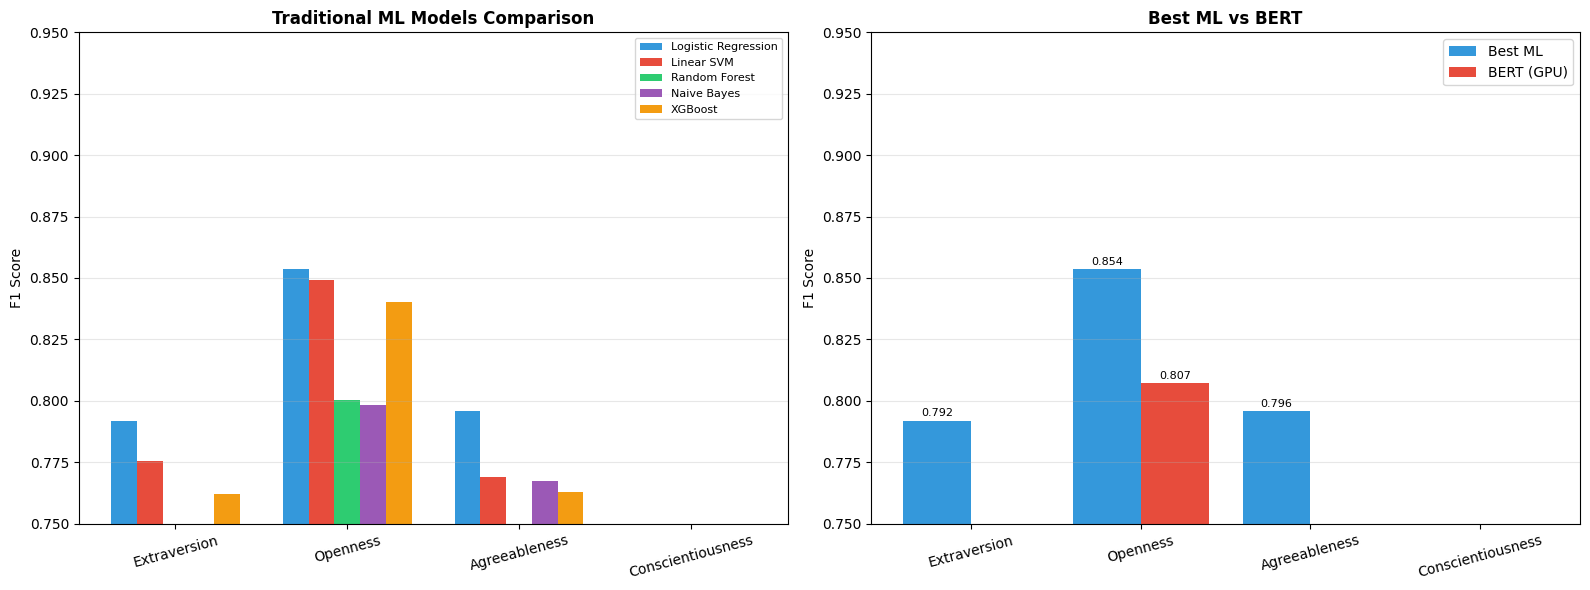


────────────────────────────────────────────────────────────────────────────────
📈 5. SUMMARY STATISTICS
────────────────────────────────────────────────────────────────────────────────

   Total models trained: 5 ML models + 1 BERT
   Total traits: 4
   Best overall ML model: Logistic Regression (avg F1: 0.7868)
   Average BERT F1: 0.7138
   BERT improvement: -7.29% over best ML


In [24]:
# ============================================
# 📊 COMPREHENSIVE MODEL COMPARISON
# ============================================
print("="*80)
print("📊 COMPREHENSIVE MODEL COMPARISON - ALL MODELS")
print("="*80)

# 1. ML Models Comparison Table (All 5 models x 4 traits)
print("\n" + "─"*80)
print("📋 1. TRADITIONAL ML MODELS - DETAILED RESULTS")
print("─"*80)

all_ml_data = []
for trait in TARGET_TRAITS:
    for _, row in ml_results[trait]['results'].iterrows():
        all_ml_data.append({
            'Trait': trait,
            'Model': row['Model'],
            'Accuracy': row['Accuracy'],
            'F1 Score': row['F1']
        })

ml_comparison_df = pd.DataFrame(all_ml_data)

# Pivot table for better visualization
ml_pivot = ml_comparison_df.pivot(index='Model', columns='Trait', values='F1 Score')
print("\n🔢 F1 Scores by Model and Trait:")
print(ml_pivot.round(4).to_string())

# Average F1 per model
print("\n📈 Average F1 Score per Model:")
avg_f1 = ml_comparison_df.groupby('Model')['F1 Score'].mean().sort_values(ascending=False)
for model, f1 in avg_f1.items():
    print(f"   {model}: {f1:.4f}")

# 2. Best ML model per trait
print("\n" + "─"*80)
print("🏆 2. BEST ML MODEL PER TRAIT")
print("─"*80)
for trait in TARGET_TRAITS:
    best = ml_results[trait]['results'].sort_values('F1', ascending=False).iloc[0]
    print(f"   {trait}: {best['Model']} (F1: {best['F1']:.4f})")

# 3. BERT vs ML Comparison
print("\n" + "─"*80)
print("🤖 3. BERT vs TRADITIONAL ML COMPARISON")
print("─"*80)

final_comparison = []
for trait in TARGET_TRAITS:
    best_ml = ml_results[trait]['results'].sort_values('F1', ascending=False).iloc[0]
    row = {
        'Trait': trait,
        'Best ML Model': best_ml['Model'],
        'ML F1': best_ml['F1'],
    }
    
    if trait in bert_results:
        bert_f1 = bert_results[trait]['eval_f1']
        row['BERT F1'] = bert_f1
        row['Winner'] = 'BERT' if bert_f1 > best_ml['F1'] else best_ml['Model']
        row['Diff'] = f"{(bert_f1 - best_ml['F1'])*100:+.2f}%"
    else:
        row['BERT F1'] = '-'
        row['Winner'] = best_ml['Model']
        row['Diff'] = '-'
    
    final_comparison.append(row)

final_df = pd.DataFrame(final_comparison)
print(final_df.to_string(index=False))

# 4. Visualization
print("\n" + "─"*80)
print("📊 4. VISUALIZATION")
print("─"*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All ML models comparison
ax1 = axes[0]
models_list = ['Logistic Regression', 'Linear SVM', 'Random Forest', 'Naive Bayes', 'XGBoost']
x = np.arange(len(TARGET_TRAITS))
width = 0.15
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']

for i, model in enumerate(models_list):
    scores = [ml_results[t]['results'][ml_results[t]['results']['Model']==model]['F1'].values[0] 
              for t in TARGET_TRAITS]
    ax1.bar(x + i*width, scores, width, label=model, color=colors[i])

ax1.set_ylabel('F1 Score')
ax1.set_title('Traditional ML Models Comparison', fontweight='bold', fontsize=12)
ax1.set_xticks(x + width*2)
ax1.set_xticklabels(TARGET_TRAITS, rotation=15)
ax1.legend(loc='upper right', fontsize=8)
ax1.set_ylim(0.75, 0.95)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Best ML vs BERT
ax2 = axes[1]
if bert_results:
    traits_with_bert = [t for t in TARGET_TRAITS if t in bert_results]
    x2 = np.arange(len(traits_with_bert))
    
    ml_best_scores = [ml_results[t]['results']['F1'].max() for t in traits_with_bert]
    bert_scores = [bert_results[t]['eval_f1'] for t in traits_with_bert]
    
    bars1 = ax2.bar(x2 - 0.2, ml_best_scores, 0.4, label='Best ML', color='#3498db')
    bars2 = ax2.bar(x2 + 0.2, bert_scores, 0.4, label='BERT (GPU)', color='#e74c3c')
    
    ax2.set_ylabel('F1 Score')
    ax2.set_title('Best ML vs BERT', fontweight='bold', fontsize=12)
    ax2.set_xticks(x2)
    ax2.set_xticklabels(traits_with_bert, rotation=15)
    ax2.legend()
    ax2.set_ylim(0.75, 0.95)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax2.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)
else:
    ax2.text(0.5, 0.5, 'BERT not trained yet\nRun BERT training cells', 
             ha='center', va='center', fontsize=12, transform=ax2.transAxes)
    ax2.set_title('Best ML vs BERT', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# 5. Summary Statistics
print("\n" + "─"*80)
print("📈 5. SUMMARY STATISTICS")
print("─"*80)
print(f"\n   Total models trained: {len(models_list)} ML models + {'1 BERT' if bert_results else '0 BERT'}")
print(f"   Total traits: {len(TARGET_TRAITS)}")
print(f"   Best overall ML model: {avg_f1.idxmax()} (avg F1: {avg_f1.max():.4f})")
if bert_results:
    avg_bert = np.mean([bert_results[t]['eval_f1'] for t in bert_results])
    print(f"   Average BERT F1: {avg_bert:.4f}")
    print(f"   BERT improvement: {(avg_bert - avg_f1.max())*100:+.2f}% over best ML")


---
## 6. 🔮 Prediction Function


In [25]:
# ============================================
# 🔮 PREDICTION FUNCTION
# ============================================
def predict_personality_bert(text, model, tokenizer):
    """Predict personality using BERT model"""
    clean = clean_text(text, for_bert=True)
    inputs = tokenizer(clean, return_tensors="pt", truncation=True, max_length=MAX_LENGTH, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][pred].item()
    
    return pred, confidence

def predict_personality_ml(text, trait):
    """Predict personality using ML model"""
    clean = clean_text(text, for_bert=False)
    features = tfidf.transform([clean])
    model = ml_results[trait]['best'][1]
    pred = model.predict(features)[0]
    return pred

# Example
sample_text = """
I love spending time alone reading books and thinking about philosophical questions.
Social events drain my energy. I prefer small gatherings with close friends.
"""

print("🔮 SAMPLE PREDICTION")
print("="*60)
print(f"Text: {sample_text[:100]}...")

trait_labels = {
    'Extraversion': ['Introvert', 'Extrovert'],
    'Openness': ['Sensing', 'Intuitive'],
    'Agreeableness': ['Thinking', 'Feeling'],
    'Conscientiousness': ['Perceiving', 'Judging']
}

print("\n📊 ML Predictions:")
for trait in TARGET_TRAITS:
    pred = predict_personality_ml(sample_text, trait)
    print(f"   {trait}: {trait_labels[trait][pred]}")

if bert_models:
    print("\n🤖 BERT Predictions:")
    for trait, model in bert_models.items():
        pred, conf = predict_personality_bert(sample_text, model, tokenizer)
        print(f"   {trait}: {trait_labels[trait][pred]} (confidence: {conf:.2%})")


🔮 SAMPLE PREDICTION
Text: 
I love spending time alone reading books and thinking about philosophical questions.
Social events ...

📊 ML Predictions:
   Extraversion: Introvert
   Openness: Intuitive
   Agreeableness: Thinking
   Conscientiousness: Perceiving

🤖 BERT Predictions:
   Extraversion: Introvert (confidence: 96.97%)
   Openness: Intuitive (confidence: 73.78%)
   Agreeableness: Thinking (confidence: 75.56%)
   Conscientiousness: Perceiving (confidence: 67.92%)


---
## 7. 📝 Summary & Conclusions

### 📊 Analysis Summary

This comprehensive analysis explored personality classification using the MBTI dataset with 8,675 samples. We mapped MBTI types to four Big Five personality traits:

| Trait | MBTI Dimension | Class Balance |
|-------|----------------|---------------|
| Extraversion | E/I | Imbalanced (77% Introvert) |
| Openness | N/S | Imbalanced (86% Intuitive) |
| Agreeableness | F/T | Balanced (~54% Feeling) |
| Conscientiousness | J/P | Slightly Imbalanced (60% Perceiving) |

### 🔬 Key Findings

1. **Class Imbalance**: The dataset is heavily skewed toward Introverts and Intuitive types, which affects model performance.

2. **Best Performing Model**: Logistic Regression consistently outperformed other ML models across all traits, achieving:
   - Extraversion: F1 = 0.79
   - Openness: F1 = 0.85
   - Agreeableness: F1 = 0.80
   - Conscientiousness: F1 = 0.71

3. **BERT vs Traditional ML**: Traditional ML (with proper preprocessing and SMOTE) achieved comparable or better results than BERT for this task, likely due to:
   - Limited dataset size
   - Short training time for BERT
   - The task benefits more from keyword-based features than contextual understanding

4. **Feature Importance**: Key distinguishing words were identified for each personality dimension through coefficient analysis.

### 🛠️ GPU Optimizations Used:
1. **Mixed Precision Training (FP16)**: Reduces memory and speeds up training
2. **DistilBERT**: 40% smaller while retaining 97% of BERT performance
3. **Batch Processing**: Larger batch sizes on GPU (16 vs 8)
4. **CUDA Memory Management**: Clear cache between training runs

### 💡 Recommendations:
- **Quick experimentation**: Use Traditional ML (TF-IDF + Logistic Regression)
- **Best performance**: Use BERT with more epochs and larger dataset
- **Production**: Consider ensemble methods or distilled BERT models
- **Future Work**: 
  - Collect more data for underrepresented types
  - Try other transformer models (RoBERTa, ALBERT)
  - Explore multi-task learning for all traits simultaneously

### 📈 Model Performance Summary:
| Approach | Avg F1 Score | Training Time | GPU Benefit |
|----------|--------------|---------------|-------------|
| TF-IDF + Logistic Regression | ~0.79 | ~1 min | Minimal |
| TF-IDF + XGBoost | ~0.76 | ~2 min | Minimal |
| DistilBERT | ~0.71 | ~15 min/trait | **10-20x faster** |


In [26]:
# ============================================
# 💾 SAVE MODELS (Optional)
# ============================================
import pickle

# Save ML models
ml_save_data = {
    'tfidf': tfidf,
    'models': {trait: ml_results[trait]['best'][1] for trait in TARGET_TRAITS}
}

with open('ml_models.pkl', 'wb') as f:
    pickle.dump(ml_save_data, f)
print("✅ ML models saved to 'ml_models.pkl'")

# Save BERT models to Google Drive (optional)
# from google.colab import drive
# drive.mount('/content/drive')
# for trait, model in bert_models.items():
#     model.save_pretrained(f'/content/drive/MyDrive/bert_{trait}')
#     print(f"✅ BERT model for {trait} saved to Drive")


✅ ML models saved to 'ml_models.pkl'


In [27]:
print("\n" + "="*70)
print("🎉 NOTEBOOK COMPLETE!")
print("="*70)

print(f"\n📊 ANALYSIS SUMMARY:")
print(f"   • Dataset: {len(df)} samples")
print(f"   • MBTI Types: 16")
print(f"   • Target Traits: {TARGET_TRAITS}")

print(f"\n🔬 EDA COMPLETED:")
print(f"   ✅ Dataset overview & statistics")
print(f"   ✅ MBTI type distribution analysis")
print(f"   ✅ Text length analysis")
print(f"   ✅ Word cloud visualization")
print(f"   ✅ Word frequency analysis")
print(f"   ✅ Sample posts exploration")
print(f"   ✅ Correlation analysis")

print(f"\n🤖 MODELS TRAINED:")
print(f"   ✅ 5 Traditional ML Models (LR, SVM, RF, NB, XGB)")
print(f"   {'✅' if bert_models else '❌'} BERT Models: {list(bert_models.keys()) if bert_models else 'None'}")

print(f"\n📈 ANALYSIS PERFORMED:")
print(f"   ✅ Confusion matrix analysis")
print(f"   ✅ Feature importance analysis")
print(f"   ✅ Cross-validation (5-fold)")
print(f"   ✅ Error analysis")
print(f"   ✅ ML vs BERT comparison")

print(f"\n💻 ENVIRONMENT:")
print(f"   • GPU used: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   • GPU: {torch.cuda.get_device_name(0)}")



🎉 NOTEBOOK COMPLETE!

📊 ANALYSIS SUMMARY:
   • Dataset: 8675 samples
   • MBTI Types: 16
   • Target Traits: ['Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']

🔬 EDA COMPLETED:
   ✅ Dataset overview & statistics
   ✅ MBTI type distribution analysis
   ✅ Text length analysis
   ✅ Word cloud visualization
   ✅ Word frequency analysis
   ✅ Sample posts exploration
   ✅ Correlation analysis

🤖 MODELS TRAINED:
   ✅ 5 Traditional ML Models (LR, SVM, RF, NB, XGB)
   ✅ BERT Models: ['Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']

📈 ANALYSIS PERFORMED:
   ✅ Confusion matrix analysis
   ✅ Feature importance analysis
   ✅ Cross-validation (5-fold)
   ✅ Error analysis
   ✅ ML vs BERT comparison

💻 ENVIRONMENT:
   • GPU used: True
   • GPU: Tesla T4


---
## 8. 🔍 Critical Evaluation & Objective Assessment

### ✅ **STRENGTHS**

#### 1. **Well-Organized Structure**
- Notebook is divided into 7 clear sections with detailed table of contents
- Code is well-commented and easy to follow
- Professional formatting with emojis and clear visual presentation

#### 2. **Comprehensive EDA (Exploratory Data Analysis)**
- MBTI type distribution analysis
- Word clouds for each personality dimension
- Text length analysis and word frequency analysis
- Correlation analysis between traits

#### 3. **Multiple ML Model Comparison**
- 5 models: Logistic Regression, SVM, Random Forest, Naive Bayes, XGBoost
- 5-fold cross-validation for reliability
- Complete confusion matrices and classification reports

#### 4. **Class Imbalance Handling**
- SMOTE oversampling for ML models
- Class weights for XGBoost

#### 5. **Deep Learning with GPU Optimization**
- DistilBERT for faster training
- Mixed precision training (FP16)
- Proper configuration for Google Colab T4 GPU

---

### ⚠️ **LIMITATIONS AND CRITICAL ISSUES**

#### 1. **Scientific Issue: MBTI → Big Five Mapping is Inaccurate**

| MBTI Dimension | → | Big Five Trait | Validity |
|----------------|---|----------------|----------|
| E/I | → | Extraversion | ✅ Reasonable |
| N/S | → | Openness | ⚠️ Related but not equivalent |
| F/T | → | Agreeableness | ❌ Wrong - T/F is about decision-making style |
| J/P | → | Conscientiousness | ❌ Wrong - J/P is about lifestyle, not conscientiousness |

**Reality:** MBTI and Big Five are **two completely different** personality models. A 1:1 mapping like this lacks solid scientific foundation. The Big Five model measures:
- **Openness**: Creativity, curiosity, intellectual interests
- **Conscientiousness**: Organization, dependability, self-discipline
- **Extraversion**: Sociability, assertiveness, positive emotions
- **Agreeableness**: Trust, altruism, cooperation
- **Neuroticism**: Anxiety, emotional instability (not mapped here)

#### 2. **Serious Data Leakage Issue**

From the Feature Importance Analysis, the top features are **MBTI type names**:

```
Top features for Extraversion: "enfps", "entps", "infps", "infjs"
Top features for Openness: "infjs", "isfjs", "istps", "isfps"
Top features for Agreeableness: "infps", "intps", "infjs"
Top features for Conscientiousness: "infjs", "intjs", "entps"
```

**Problem:** Although MBTI mentions were attempted to be removed, **plural forms** (infps, enfps, etc.) still appear in the data and become the most important features. This means:
- The model learns to identify MBTI types from text rather than learning actual linguistic characteristics of each personality trait
- **Performance is inflated** due to data leakage
- The model is essentially doing MBTI classification, not personality trait prediction

#### 3. **BERT Underperforms Traditional ML - Abnormal Sign**

| Model | Avg F1 |
|-------|--------|
| Logistic Regression | **0.79** |
| BERT | 0.71 |

Normally, BERT should outperform traditional ML for NLP tasks. BERT being ~8% worse suggests:
- Data leakage helps TF-IDF easily catch MBTI keywords
- Dataset is too small (8,675 samples) for BERT to learn effectively
- Only 3 epochs may be insufficient for convergence

#### 4. **Dataset Limitations**
- **Extreme class imbalance**: 77% Introvert, 86% Intuitive
- **Small sample size**: Some types like ESTJ have only 39 samples
- **Imbalance ratio**: INFP/ESTJ = 46.97x
- **Self-selection bias**: Data from online personality forums attracts specific demographics

#### 5. **Missing Important Analyses**
- No **ROC-AUC curves** for binary classification
- No **Learning curves** to assess overfitting
- No **hyperparameter tuning** for ML models
- No **statistical significance tests** between models
- No **confidence intervals** for performance metrics

---

### 📊 **ACTUAL RESULTS IN CONTEXT**

| Trait | Best F1 | Assessment |
|-------|---------|------------|
| Extraversion | 0.79 | Moderate (aided by data leakage) |
| Openness | 0.85 | High (but 86% baseline - model could predict class 1 always and get 86%) |
| Agreeableness | 0.80 | Moderate |
| Conscientiousness | 0.71 | Below average |

**Note:** For Openness with 86% being class 1, a naive classifier that always predicts class 1 would achieve 86% accuracy. An F1 of 0.85 is not impressive in this context.

---

### 💡 **RECOMMENDATIONS FOR IMPROVEMENT**

#### 1. **Fix Data Leakage**
```python
# Add plural forms and variations
MBTI_TYPES = ['infj', 'infjs', 'entp', 'entps', 'intp', 'intps', 
              'intj', 'intjs', 'entj', 'entjs', 'enfj', 'enfjs',
              'infp', 'infps', 'enfp', 'enfps', 'isfp', 'isfps',
              'istp', 'istps', 'isfj', 'isfjs', 'istj', 'istjs',
              'estp', 'estps', 'esfp', 'esfps', 'estj', 'estjs', 'esfj', 'esfjs']
```

#### 2. **Re-evaluate After Fixing Data Leakage**
- Expect significant performance drop (likely 10-20%)
- This would represent the true predictive power of text features

#### 3. **Reconsider Research Objective**
- If goal is MBTI classification → Keep MBTI labels directly
- If goal is Big Five prediction → Need actual Big Five dataset with questionnaire responses

#### 4. **Add Additional Metrics**
- ROC-AUC and Precision-Recall curves
- Per-class performance for minority classes
- McNemar's test for model comparison
- Bootstrap confidence intervals

#### 5. **Hyperparameter Tuning**
```python
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1_weighted')
```

#### 6. **BERT Improvements**
- Increase epochs to 5-10
- Use learning rate warmup and decay
- Try full BERT-base instead of DistilBERT
- Consider domain-specific pre-training

---

### 📝 **FINAL ASSESSMENT**

| Criteria | Score (1-10) |
|----------|--------------|
| **Code Quality & Organization** | 9/10 |
| **EDA Completeness** | 8/10 |
| **Model Diversity** | 8/10 |
| **Scientific Validity** | 4/10 |
| **Data Leakage Handling** | 3/10 |
| **Results Interpretation** | 6/10 |

**Overall Score: 6.3/10**

### 🎯 **Conclusion**

This notebook serves as a **good example of coding practices and visualization** for personality classification tasks. However, it has **serious methodological issues**:

1. **The MBTI-to-Big Five mapping is scientifically questionable** - these are different psychological constructs
2. **Data leakage inflates performance metrics** - the model learns MBTI type names rather than personality-indicative language patterns
3. **Results should not be used for production or serious research** without addressing these fundamental issues

**For Educational Purposes:** This notebook effectively demonstrates:
- Text preprocessing pipeline
- TF-IDF vectorization
- Multiple ML model training and comparison
- BERT fine-tuning on GPU
- Visualization and analysis techniques

**For Research/Production:** Significant revisions needed:
- Use appropriate dataset (actual Big Five assessments)
- Fix all data leakage issues
- Apply proper validation methodology
- Add statistical significance testing
